In [1]:
import itertools
import json
import operator
import os
from pathlib import Path
from pprint import pprint
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

## Load data and preprocess

### Metadata

In [2]:
# Map from test suite tag to high-level circuit.
circuits = {
    "Licensing": ["npi", "reflexive"],
    "Long-Distance Dependencies": ["fgd", "cleft"],
    "Agreement": ["number"],
    "Garden-Path Effects": ["npz", "mvrr"],
    "Gross Syntactic State": ["subordination"],
    "Center Embedding": ["center"],
}

tag_to_circuit = {tag: circuit
                  for circuit, tags in circuits.items()
                  for tag in tags}

In [3]:
# Map codenames to readable names for various columns.
PRETTY_COLUMN_MAPS = [
    ("model_name",
     {
        "vanilla": "LSTM",
        "ordered-neurons": "ON-LSTM",
        "rnng": "RNNG",
        "ngram": "n-gram",
        "random": "Random",
         
        "gpt-2": "GPT-2",
        "gpt-2-xl": "GPT-2-XL",
        "gpt-2-nobpe": "GPT-2 (no BPE)",
        "transformer-xl": "Transformer-XL",
        "grnn": "GRNN",
        "jrnn": "JRNN",
    }),
    
    ("corpus", lambda x: x.upper() if x else "N/A"),
]
PRETTY_COLUMNS = ["pretty_%s" % col for col, _ in PRETTY_COLUMN_MAPS]

In [4]:
# Exclusions
exclude_suite_re = re.compile(r"^fgd-embed[34]|^gardenpath|^nn-nv")
exclude_models = ["1gram", "ngram-no-rand"] # "ngram", 

In [67]:
ngram_models = ["1gram", "ngram", "ngram-single"]
baseline_models = ["random"]

# Models for which we designed a controlled training regime
controlled_models = ["ngram", "ordered-neurons", "vanilla", "rnng", "gpt-2", "gpt-2-nobpe"]

### Load

In [68]:
ppl_data_path = Path("../data/raw/perplexity.csv")
test_suite_results_path = Path("../data/raw/test_suite_results")

In [69]:
perplexity_df = pd.read_csv(ppl_data_path, index_col=["model", "corpus", "seed"])
perplexity_df.index.set_names("model_name", level=0, inplace=True)

results_df = pd.concat([pd.read_csv(f) for f in test_suite_results_path.glob("*.csv")])

# Split model_id into constituent parts
model_ids = results_df.model.str.split("_", expand=True).rename(columns={0: "model_name", 1: "corpus", 2: "seed"})
results_df = pd.concat([results_df, model_ids], axis=1).drop(columns=["model"])
results_df["seed"] = results_df.seed.fillna("0").astype(int)

# Add tags
results_df["tag"] = results_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
results_df["circuit"] = results_df.tag.map(tag_to_circuit)
tags_missing_circuit = set(results_df.tag.unique()) - set(tag_to_circuit.keys())
if tags_missing_circuit:
    print("Tags missing circuit: ", ", ".join(tags_missing_circuit))

Tags missing circuit:  nn


In [70]:
# Exclude test suites
exclude_filter = results_df.suite.str.contains(exclude_suite_re)
print("Dropping %i results / %i suites due to exclusions:"
      % (exclude_filter.sum(), len(results_df[exclude_filter].suite.unique())))
print(" ".join(results_df[exclude_filter].suite.unique()))
results_df = results_df[~exclude_filter]

# Exclude models
exclude_filter = results_df.model_name.isin(exclude_models)
print("Dropping %i results due to dropping models:" % exclude_filter.sum(), list(results_df[exclude_filter].model_name.unique()))
results_df = results_df[~exclude_filter]

Dropping 53965 results / 3 suites due to exclusions:
fgd-embed3 nn-nv-rpl fgd-embed4
Dropping 6392 results due to dropping models: ['1gram', 'ngram-no-rand']


In [71]:
# Average across seeds of each ngram model.
# The only difference between "seeds" of these model types are random differences in tie-breaking decisions.
for ngram_model in ngram_models:
    # Create a synthetic results_df with one ngram model, where each item is correct if more than half of
    # the ngram seeds vote.
    ngram_results_df = (results_df[results_df.model_name == ngram_model].copy()
                        .groupby(["model_name", "corpus", "suite", "item", "tag", "circuit"])
                        .agg({"correct": "mean"}) > 0.5).reset_index()
    ngram_results_df["seed"] = 0
    
    # Drop existing model results.
    results_df = pd.concat([results_df[~(results_df.model_name == ngram_model)],
                            ngram_results_df], sort=True)

In [72]:
# Prettify name columns, which we'll carry through data manipulations
for column, map_fn in PRETTY_COLUMN_MAPS:
    pretty_column = "pretty_%s" % column
    results_df[pretty_column] = results_df[column].map(map_fn)
    if results_df[pretty_column].isna().any():
        print("WARNING: In prettifying %s, yielded NaN values:" % column)
        print(results_df[results_df[pretty_column].isna()])

### Data prep

In [73]:
suites_df = results_df.groupby(["model_name", "corpus", "seed", "suite"] + PRETTY_COLUMNS).correct.mean().reset_index()
suites_df["tag"] = suites_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
suites_df["circuit"] = suites_df.tag.map(tag_to_circuit)

# For controlled evaluation:
# Compute a model's test suite accuracy relative to the mean accuracy on this test suite.
# Only compute this on controlled models.
def get_controlled_mean(suite_results):
    # When computing test suite mean, first collapse test suite accuracies within model--corpus, then combine resulting means.
    return suite_results[suite_results.model_name.isin(controlled_models)].groupby(["model_name", "corpus"]).correct.mean().mean()
suite_means = suites_df.groupby("suite").apply(get_controlled_mean)
suites_df["correct_delta"] = suites_df.apply(lambda r: r.correct - suite_means.loc[r.suite] if r.model_name in controlled_models else None, axis=1)

In [74]:
# Join PPL and accuracy data.
joined_data = suites_df.groupby(["model_name", "corpus", "seed"] + PRETTY_COLUMNS)[["correct", "correct_delta"]].agg("mean")
joined_data = pd.DataFrame(joined_data).join(perplexity_df).reset_index()
joined_data.head()

,model_name,corpus,seed,pretty_model_name,pretty_corpus,correct,correct_delta,pid,test_loss,test_ppl
0,gpt-2,,0,GPT-2,N/A,0.784176,0.350829,NaN,NaN,NaN
1,gpt-2,bllip-lg,1581955288,GPT-2,BLLIP-LG,0.750934,0.317588,NaN,NaN,32.138346
2,gpt-2,bllip-md,1581861474,GPT-2,BLLIP-MD,0.755106,0.321760,NaN,NaN,37.346935
3,gpt-2,bllip-md,1582126320,GPT-2,BLLIP-MD,0.774052,0.340706,NaN,NaN,36.724854
4,gpt-2,bllip-sm,1581807578,GPT-2,BLLIP-SM,0.231621,-0.201726,NaN,NaN,183.098872


In [75]:
# Join PPL and accuracy data, splitting on circuit.
joined_data_circuits = suites_df.groupby(["model_name", "corpus", "seed", "circuit"] + PRETTY_COLUMNS)[["correct", "correct_delta"]].agg("mean")
joined_data_circuits = pd.DataFrame(joined_data_circuits).reset_index().set_index(["model_name", "corpus", "seed"]).join(perplexity_df).reset_index()
joined_data_circuits.head()

,model_name,corpus,seed,circuit,pretty_model_name,pretty_corpus,correct,correct_delta,pid,test_loss,test_ppl
0,gpt-2,,0,Agreement,GPT-2,N/A,0.736842,0.484744,NaN,NaN,NaN
1,gpt-2,,0,Center Embedding,GPT-2,N/A,0.892857,0.257635,NaN,NaN,NaN
2,gpt-2,,0,Garden-Path Effects,GPT-2,N/A,0.880952,0.270927,NaN,NaN,NaN
3,gpt-2,,0,Gross Syntactic State,GPT-2,N/A,0.891304,0.303009,NaN,NaN,NaN
4,gpt-2,,0,Licensing,GPT-2,N/A,0.657895,0.470195,NaN,NaN,NaN


In [76]:
# Analyze stability to modification.
def has_modifier(ts):
    if ts.endswith(("_modifier", "_mod")):
        return True
    else:
        return None
suites_df["has_modifier"] = suites_df.suite.transform(has_modifier)

# Mark "non-modifier" test suites
modifier_ts = suites_df[suites_df.has_modifier == True].suite.unique()
no_modifier_ts = [re.sub(r"_mod(ifier)?$", "", ts) for ts in modifier_ts]
suites_df.loc[suites_df.suite.isin(no_modifier_ts), "has_modifier"] = False
# Store subset of test suites which have definite modifier/no-modifier marking
suites_df_mod = suites_df[~(suites_df.has_modifier.isna())].copy()
suites_df_mod["has_modifier"] = suites_df_mod.has_modifier.astype(bool)
# Get base test suite (without modifier/no-modifier marking)
suites_df_mod["test_suite_base"] = suites_df_mod.suite.transform(lambda ts: ts.strip("_no-modifier").strip("_modifier"))
suites_df_mod.head()

,model_name,corpus,seed,suite,pretty_model_name,pretty_corpus,correct,tag,circuit,correct_delta,has_modifier,test_suite_base
0,gpt-2,,0,center_embed,GPT-2,N/A,0.928571,center,Center Embedding,0.249094,False,center_emb
1,gpt-2,,0,center_embed_mod,GPT-2,N/A,0.857143,center,Center Embedding,0.266175,True,center_emb
2,gpt-2,,0,cleft,GPT-2,N/A,1.000000,cleft,Long-Distance Dependencies,0.174094,False,cleft
3,gpt-2,,0,cleft_modifier,GPT-2,N/A,0.925000,cleft,Long-Distance Dependencies,0.405435,True,cleft
8,gpt-2,,0,mvrr,GPT-2,N/A,0.785714,mvrr,Garden-Path Effects,0.223214,False,v


### Checks

In [77]:
# Each model--corpus--seed should have perplexity data.
ids_from_results = results_df.set_index(["model_name", "corpus", "seed"]).sort_index().index
ids_from_ppl = perplexity_df.sort_index().index
diff = set(ids_from_results) - set(ids_from_ppl)
if diff:
    print("Missing perplexity results for:")
    pprint(diff)
    #raise ValueError("Each model--corpus--seed must have perplexity data.")

Missing perplexity results for:
{('gpt-2', '', 0),
 ('gpt-2-xl', '', 0),
 ('grnn', '', 0),
 ('jrnn', '', 0),
 ('random', '', 1),
 ('random', '', 2),
 ('random', '', 3),
 ('random', '', 4),
 ('random', '', 5),
 ('random', '', 6),
 ('random', '', 7),
 ('random', '', 8),
 ('random', '', 9),
 ('random', '', 10),
 ('random', '', 11),
 ('random', '', 12),
 ('random', '', 13),
 ('random', '', 14),
 ('random', '', 15),
 ('random', '', 16),
 ('random', '', 17),
 ('random', '', 18),
 ('random', '', 19),
 ('random', '', 20),
 ('random', '', 21),
 ('random', '', 22),
 ('random', '', 23),
 ('random', '', 24),
 ('random', '', 25),
 ('random', '', 26),
 ('random', '', 27),
 ('random', '', 28),
 ('random', '', 29),
 ('random', '', 30),
 ('random', '', 31),
 ('random', '', 32),
 ('random', '', 33),
 ('random', '', 34),
 ('random', '', 35),
 ('random', '', 36),
 ('random', '', 37),
 ('random', '', 38),
 ('random', '', 39),
 ('random', '', 40),
 ('random', '', 41),
 ('random', '', 42),
 ('random', '', 43

In [78]:
# Every model--corpus--seed should have results for all test suite items.
item_list = {model_key: set(results.suite)
             for model_key, results in results_df.groupby(["model_name", "corpus", "seed"])}
not_shared = set()
for k1, k2 in itertools.combinations(item_list.keys(), 2):
    l1, l2 = item_list[k1], item_list[k2]
    if l1 != l2:
        print("SyntaxGym test suite results for %s and %s don't match" % (k1, k2))
        print("\tIn %s but not in %s:\n\t\t%s" % (k2, k1, l2 - l1))
        print("\tIn %s but not in %s:\n\t\t%s" % (k1, k2, l1 - l2))
        print()
        
        not_shared |= l2 - l1
        not_shared |= l1 - l2

if len(not_shared) > 0:
    to_drop = results_df[results_df.suite.isin(not_shared)]
    print("Dropping these test suites (%i rows) for now. Yikes:" % len(to_drop))
    print(not_shared)
    results_df = results_df[~results_df.suite.isin(not_shared)]
else:
    print("OK")

OK


In [79]:
# Second sanity check: same number of results per model--corpus--seed
result_counts = results_df.groupby(["model_name", "corpus", "seed"]).item.count()
if len(result_counts.unique()) > 1:
    print("WARNING: Some model--corpus--seed combinations have more result rows in results_df than others.")
    print(result_counts)

In [80]:
# Second sanity check: same number of suite-level results per model--corpus--seed
suite_result_counts = suites_df.groupby(["model_name", "corpus", "seed"]).suite.count()
if len(suite_result_counts.unique()) > 1:
    print("WARNING: Some model--corpus--seed combinations have more result rows in suites_df than others.")
    print(suite_result_counts)

## Prepare for data rendering

In [81]:
RENDER_FINAL = False
figure_path = Path("../reports/figures")
figure_path.mkdir(exist_ok=True, parents=True)

RENDER_CONTEXT = {
    "font_scale": 3.5,
    "rc": {"lines.linewidth": 2.5, "hatch.linewidth":3},
    "style": "ticks",
    "font": "Liberation Sans"
}
sns.set(**RENDER_CONTEXT)

In [82]:
BASELINE_LINESTYLE = {
    "color": "gray",
    "linestyle": "--",
}
CORPUS_MARKERS = {
    "BLLIP-LG": "s",
    "BLLIP-MD": "v",
    "BLLIP-SM": "P",
    "BLLIP-XS": "X"
}
p = sns.color_palette()[:len(joined_data.model_name.unique())]
MODEL_COLORS = {
    "LSTM": p[0],
    "ON-LSTM": p[3],
    "RNNG": p[2],
    "n-gram": "saddlebrown",
    "Random": "darkgrey",
         
    "GPT-2": p[1],
    "GPT-2-XL": p[4],
    "GPT-2 (no BPE)": p[7],
    "Transformer-XL": p[5],
    "GRNN": p[6],
    "JRNN": "gold"
}

In [83]:
def render_final(path):
    sns.despine()
    plt.tight_layout()
    plt.savefig(path)

In [84]:
# Standardize axis labels
SG_ABSOLUTE_LABEL = "SG score"
SG_DELTA_LABEL = "SG score delta"
PERPLEXITY_LABEL = "Test perplexity"

In [85]:
# Establish consistent orderings of model names, corpus names, circuit names
# for figure ordering / coloring. (NB these refer to prettified names)
model_order = sorted(set(results_df.pretty_model_name))
controlled_model_order = sorted(set(results_df[results_df.model_name.isin(controlled_models)].pretty_model_name))
corpus_order = ["BLLIP-LG", "BLLIP-MD", "BLLIP-SM", "BLLIP-XS"]
circuit_order = sorted([c for c in results_df.circuit.dropna().unique()])

## Main analyses

### Basic barplots

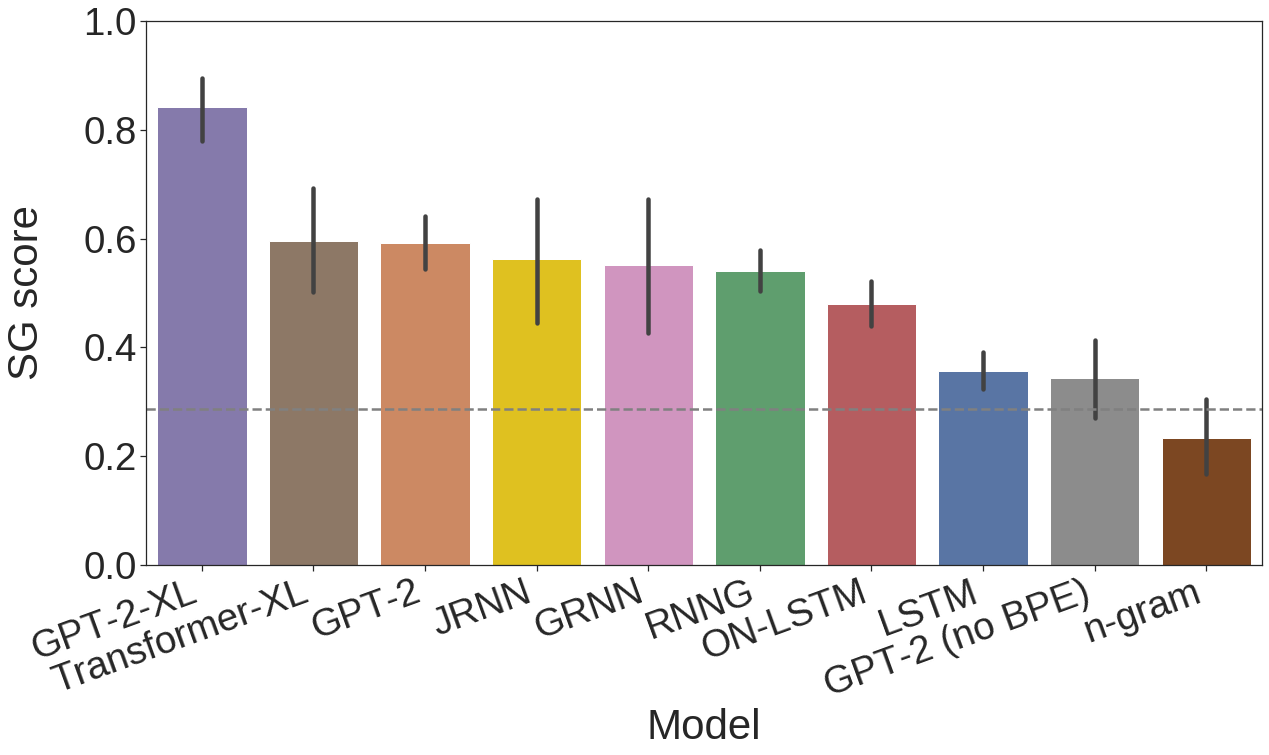

In [86]:
f, ax = plt.subplots(figsize=(20, 10))

# Exclude random baseline; will plot as horizontal line
plot_df = suites_df[suites_df.model_name != "random"]

# Sort by decreasing average accuracy.
order = list(plot_df.groupby("pretty_model_name").correct.mean().sort_values(ascending=False).index)

current_palette = sns.color_palette()[:len(order)]
sns.barplot(data=plot_df.reset_index(), x="pretty_model_name", y="correct", order=order, ax=ax, palette=MODEL_COLORS)#palette=reversed(current_palette))

# Plot random chance baseline
ax.axhline(suites_df[suites_df.model_name == "random"].correct.mean(), **BASELINE_LINESTYLE)

ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment="right")

ax.set_ylim(0,1)

plt.xlabel("Model")
plt.ylabel(SG_ABSOLUTE_LABEL, labelpad=36)

if RENDER_FINAL:
    render_final(figure_path / "overall.pdf")

### Controlled evaluation of model type + dataset size

In [87]:
controlled_suites_df = suites_df[suites_df.model_name.isin(controlled_models)]
controlled_suites_df_mod = suites_df_mod[suites_df_mod.model_name.isin(controlled_models)]
controlled_joined_data_circuits = joined_data_circuits[joined_data_circuits.model_name.isin(controlled_models)]

Text(0.5, 1.0, 'Controlled GPT-2 SG evaluations by tag and training corpus')

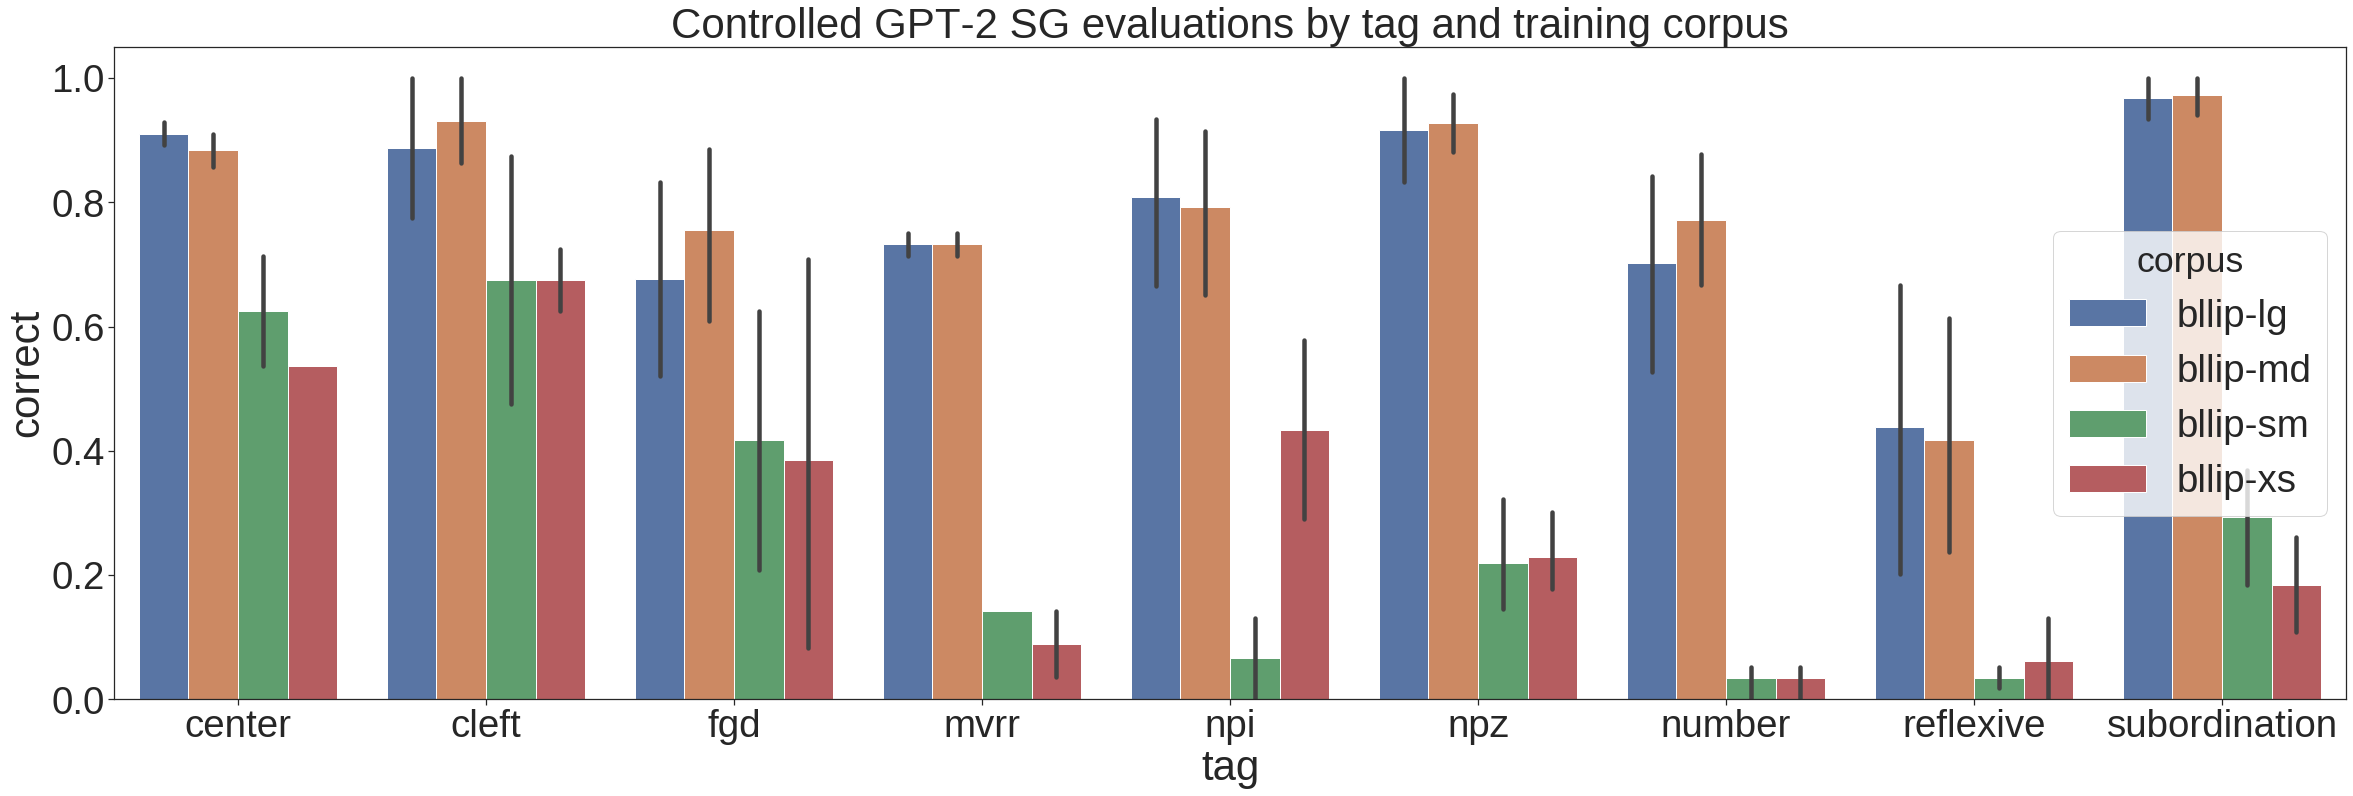

In [89]:
plt.subplots(figsize=(40, 12))
sns.barplot(data=controlled_suites_df[(controlled_suites_df.model_name == "gpt-2") & ~(controlled_suites_df.corpus == "")].reset_index(),
            x="tag", hue="corpus", y="correct")
plt.title("Controlled GPT-2 SG evaluations by tag and training corpus")

Text(0.5, 1.0, 'Controlled GPT-2 (no BPE) SG evaluations by tag and training corpus')

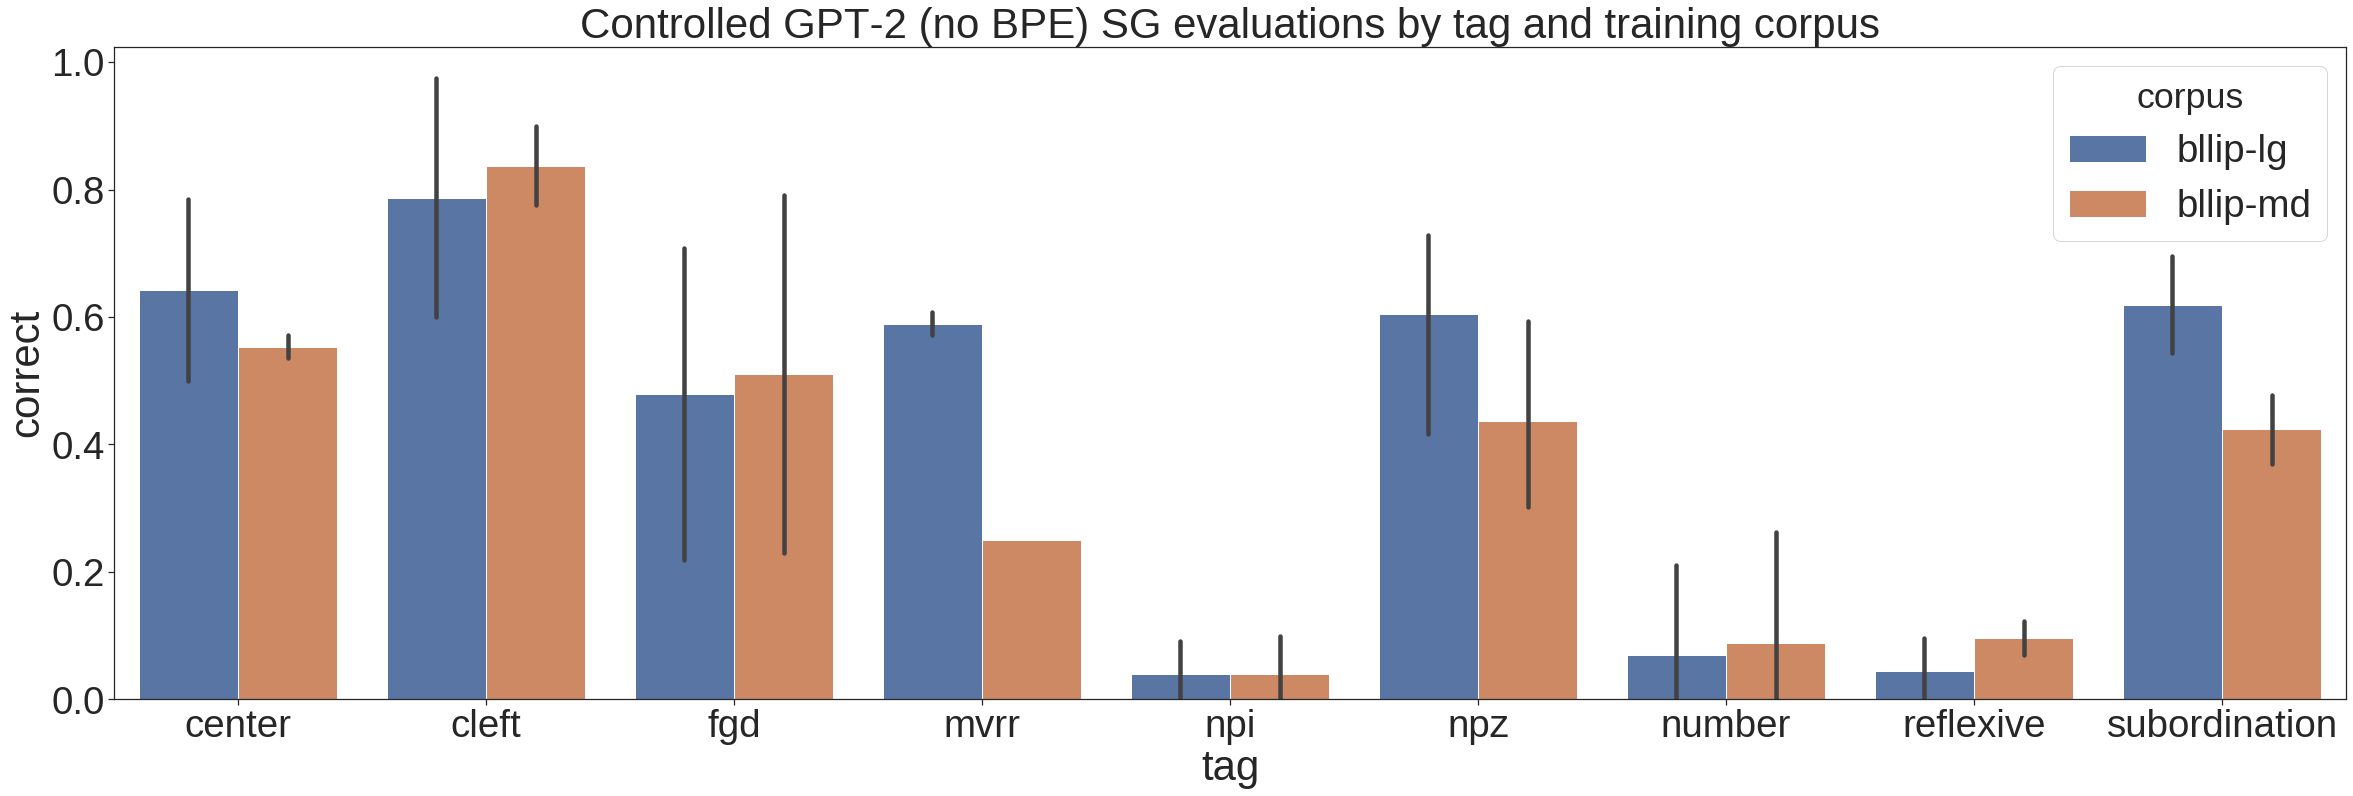

In [90]:
plt.subplots(figsize=(40, 12))
sns.barplot(data=controlled_suites_df[controlled_suites_df.model_name == "gpt-2-nobpe"].reset_index(),
            x="tag", hue="corpus", y="correct")
plt.title("Controlled GPT-2 (no BPE) SG evaluations by tag and training corpus")

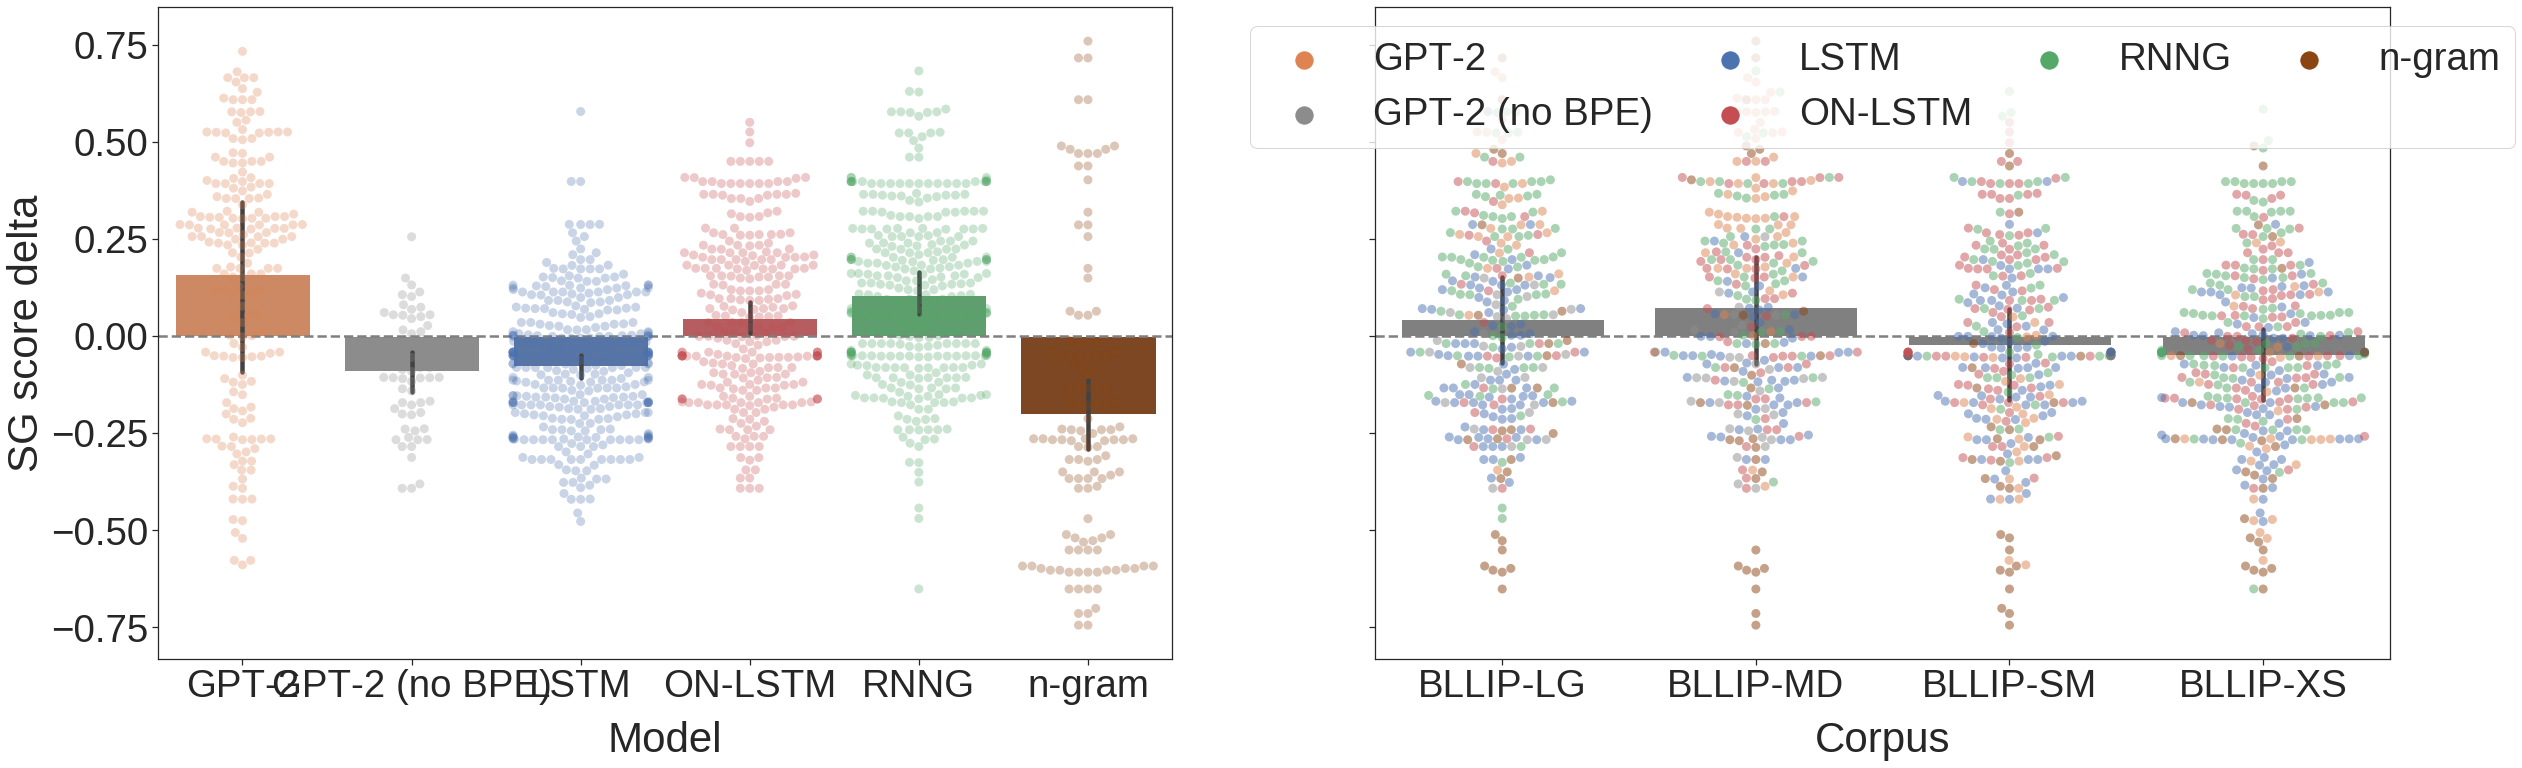

In [91]:
_, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(40,12))
for i, ax in enumerate(axes):
    ax.axhline(0, c="gray", linestyle="--")
    if i == 0:
        sns.barplot(data=controlled_suites_df.reset_index(), 
                    x="pretty_model_name", y="correct_delta", palette=MODEL_COLORS,
                    units="corpus", order=controlled_model_order, ax=ax)
        sns.swarmplot(data=controlled_suites_df.reset_index(),
                      x="pretty_model_name", y="correct_delta", palette=MODEL_COLORS,
                      order=controlled_model_order, alpha=0.3, ax=ax, size=9)

        ax.set_xlabel("Model", labelpad=16)
        ax.set_ylabel(SG_DELTA_LABEL)
    elif i == 1:
        # Estimate error intervals with a structured bootstrap: resampling units = model
        sns.barplot(data=controlled_suites_df.reset_index(), x="pretty_corpus", y="correct_delta",
                    color="Gray", units="pretty_model_name", order=corpus_order, ax=ax)
        sns.swarmplot(data=controlled_suites_df.reset_index(), x="pretty_corpus", y="correct_delta",
                      hue="pretty_model_name", order=corpus_order, hue_order=controlled_model_order,
                      palette=MODEL_COLORS, size=9, alpha=0.5, ax=ax)

        handles, labels = ax.get_legend_handles_labels()
        for h in handles:
            h.set_sizes([300.0])

        ax.set_xlabel("Corpus", labelpad=16)
        ax.set_ylabel("")
        ax.legend(handles, labels, loc="upper center", ncol=4, columnspacing=1)

if RENDER_FINAL:
    render_final(figure_path / "controlled.pdf")

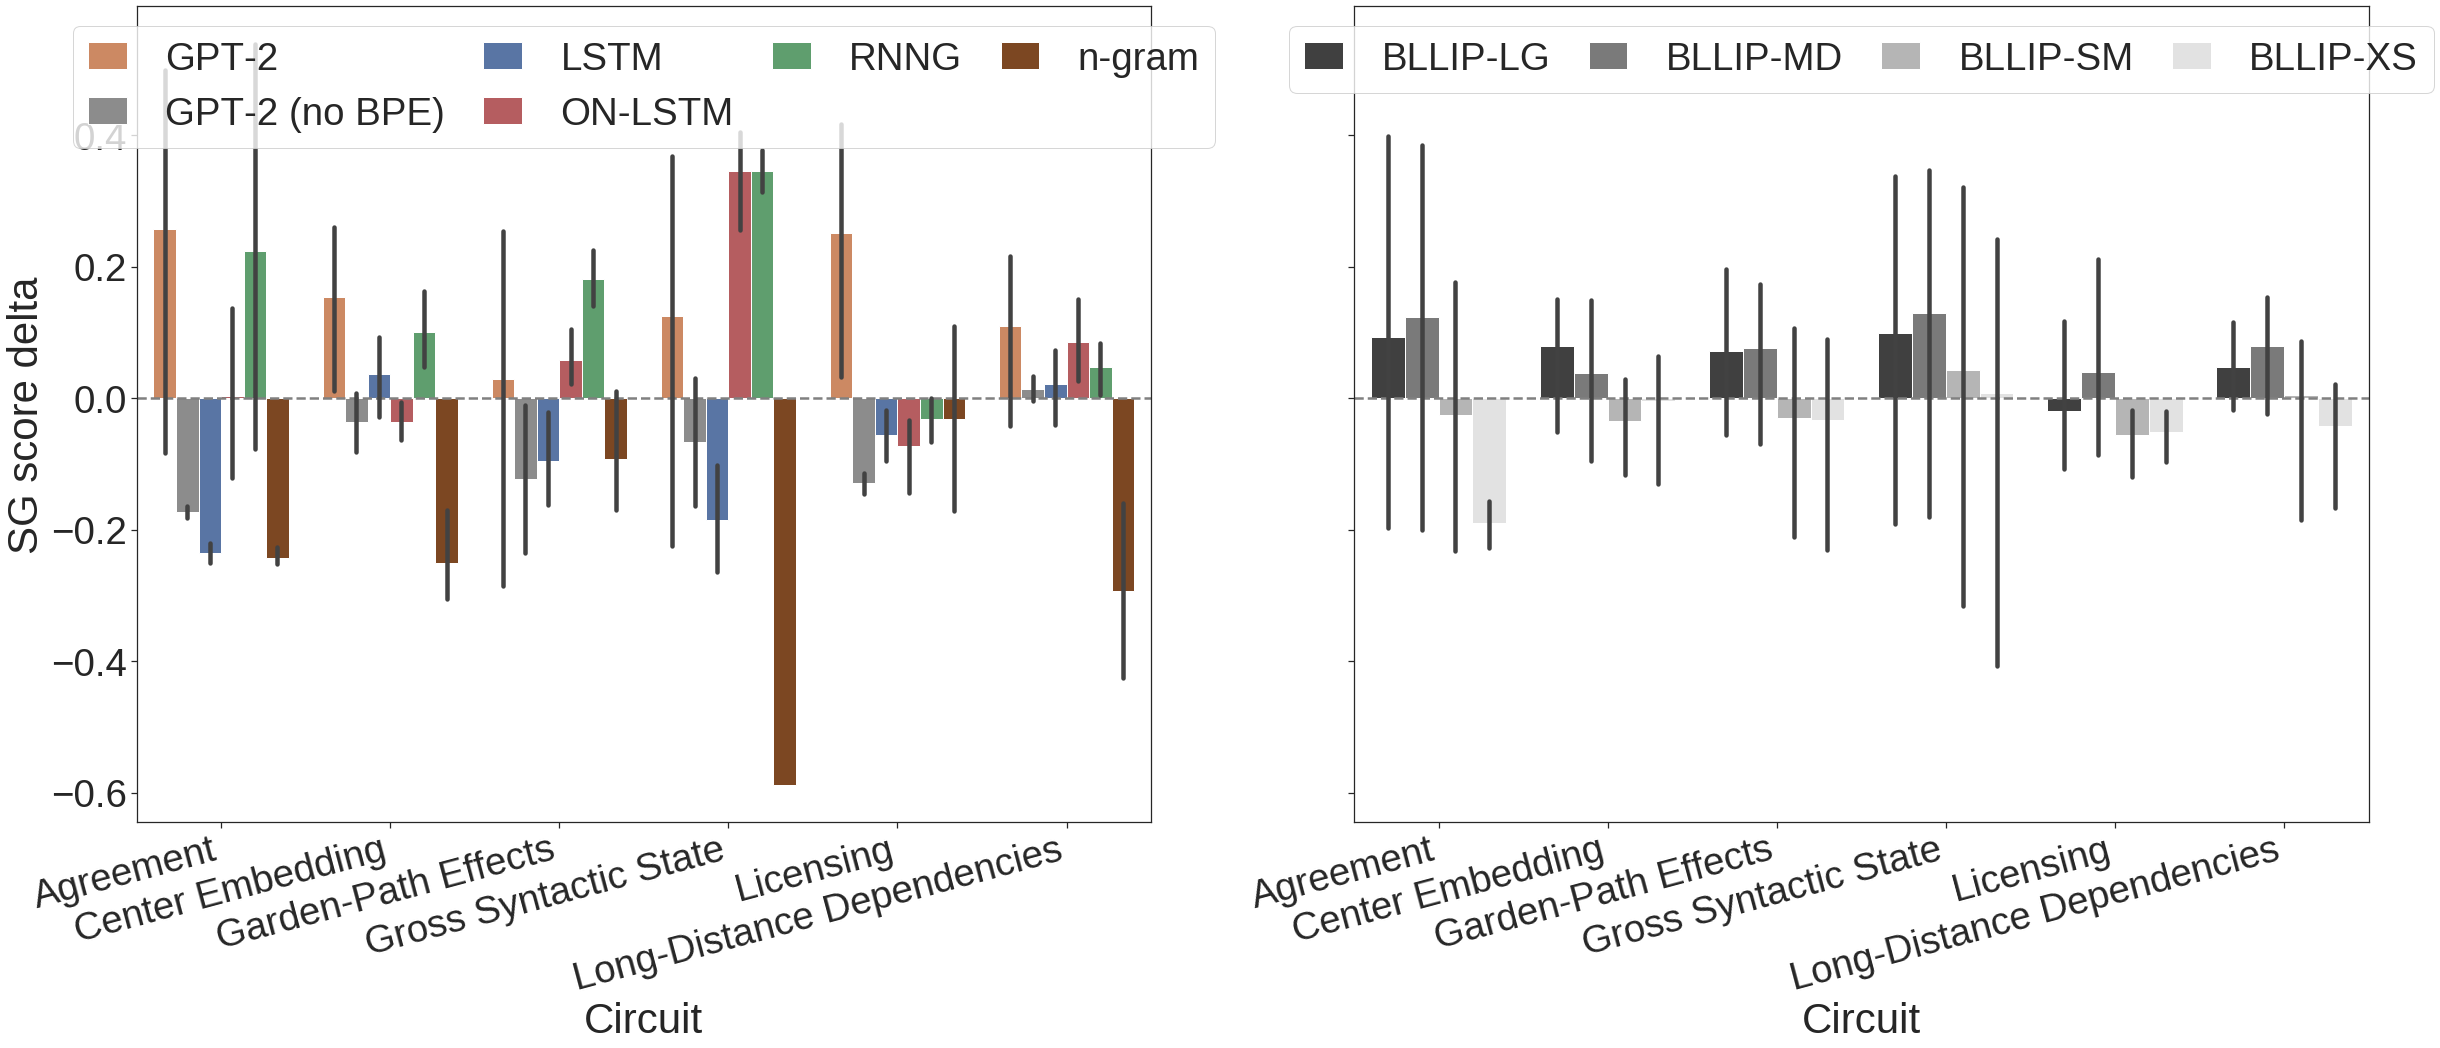

In [92]:
_, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(40,15))
legend_params=dict(title="", ncol=4, loc="upper center", columnspacing=1, handlelength=1, handletextpad=1)

for i, ax in enumerate(axes):
    ax.axhline(0, **BASELINE_LINESTYLE)
    if i == 0:
        sns.barplot(data=controlled_joined_data_circuits, x="circuit", y="correct_delta",
                    hue="pretty_model_name", units="corpus", hue_order=controlled_model_order,
                    ax=ax, palette=MODEL_COLORS)
        ax.set_ylabel(SG_DELTA_LABEL)
    elif i == 1:
        sns.barplot(data=controlled_joined_data_circuits, x="circuit", y="correct_delta",
                    hue="pretty_corpus", units="model_name", hue_order=corpus_order,
                    ax=ax, palette="Greys_r")
        ax.set_ylabel("")
        
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
    ax.set_xlabel("Circuit")
    ax.legend(**legend_params)

if RENDER_FINAL:
    render_final(figure_path / "controlled_circuit.pdf")

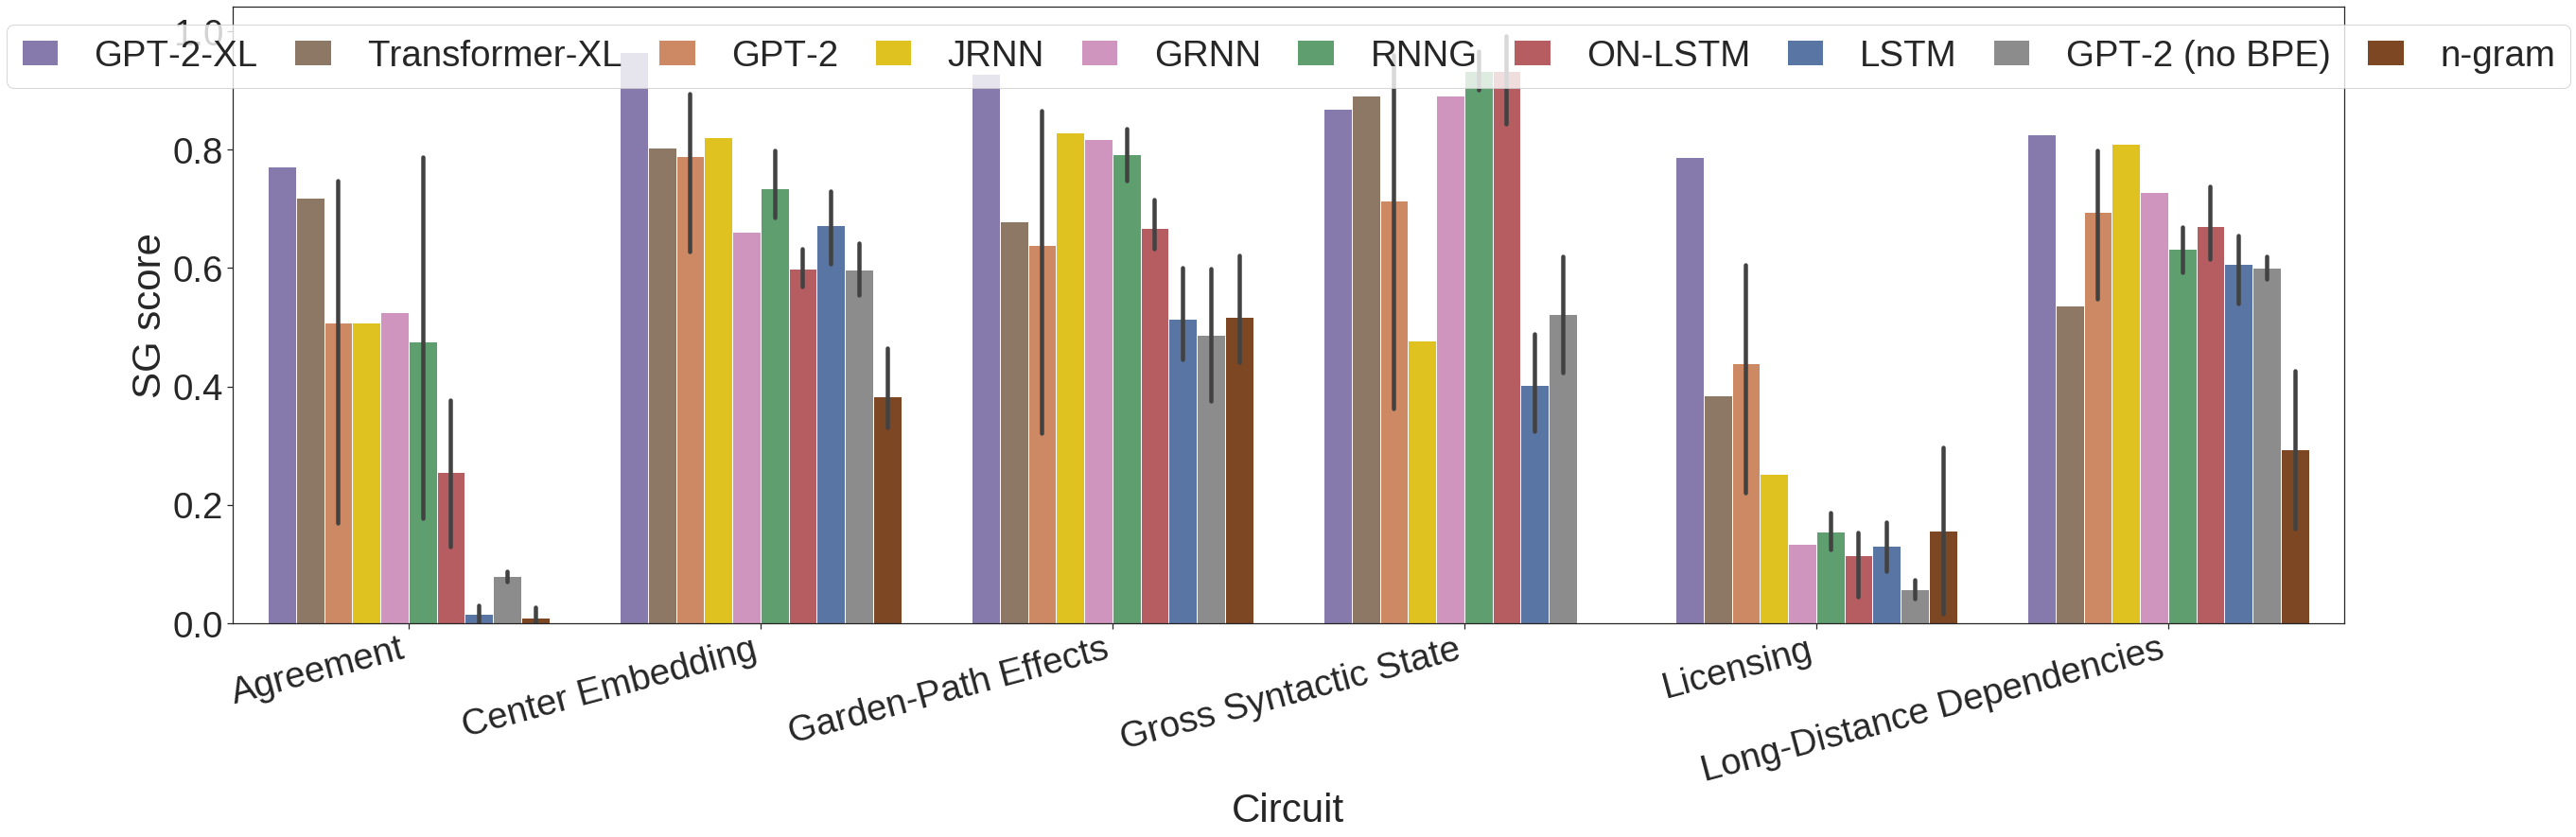

In [93]:
_, ax = plt.subplots(figsize=(40,12))
joined_data_circuits_norandom = joined_data_circuits[joined_data_circuits.pretty_model_name != "Random"]
order = list(plot_df.groupby("pretty_model_name").correct.mean().sort_values(ascending=False).index)
sns.barplot(data=joined_data_circuits_norandom, x="circuit", y="correct",
            hue="pretty_model_name", units="corpus", hue_order=order, ax=ax, palette=MODEL_COLORS)

ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
ax.set_xlabel("Circuit")
ax.set_ylabel(SG_ABSOLUTE_LABEL)
ax.legend(title="", ncol=len(order), loc="upper center", columnspacing=1, handlelength=1, handletextpad=1)

if RENDER_FINAL:
    render_final(figure_path / "allmodels_circuit.pdf")

#### Stability to modification

In [94]:
controlled_suites_df_mod.suite.unique()

array(['center_embed', 'center_embed_mod', 'cleft', 'cleft_modifier',
       'mvrr', 'mvrr_mod', 'npz_ambig', 'npz_ambig_mod', 'npz_obj',
       'npz_obj_mod'], dtype=object)

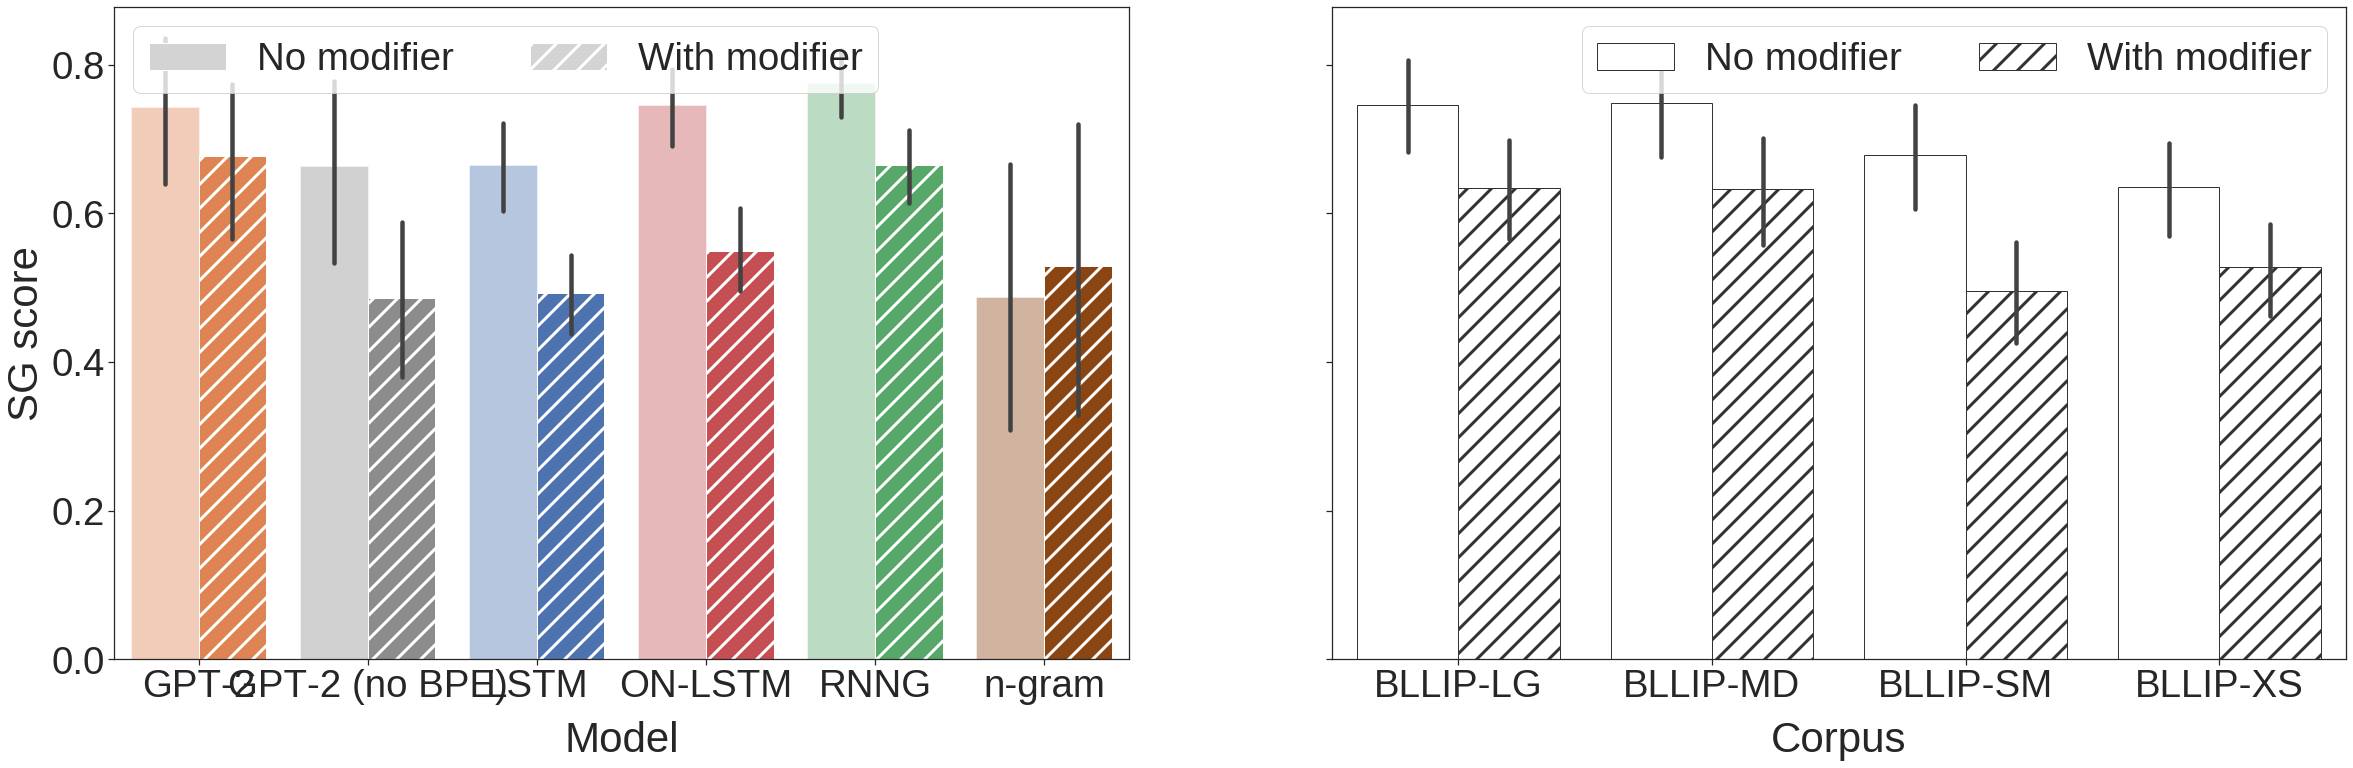

In [95]:
HATCH = "/"
MOD_STABILITY_LABELS = ["No modifier", "With modifier"]

def add_hatches(patches, hatch="/"):
    sorted_patches = sorted(patches, key=lambda bar: bar.get_x())
    for i, bar in enumerate(sorted_patches):
        if i % 2 != 0:
            bar.set_hatch(hatch)

_, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(40,12))
for i, ax in enumerate(axes):
    if i == 0:
        sns.barplot(data=controlled_suites_df_mod, x="pretty_model_name", y="correct",
                    hue="has_modifier", order=controlled_model_order, ax=ax)
        
        # Change colors, alphas, hatches.
        sorted_patches = sorted(ax.patches, key=lambda bar: bar.get_x())
        colors = [MODEL_COLORS[controlled_model_order[i]] for i in range(len(controlled_model_order))]
        for i, bar in enumerate(sorted_patches):
            bar.set_facecolor(colors[int(i/2)])
            if i % 2 == 0:
                bar.set_alpha(0.4)
        add_hatches(ax.patches, hatch=HATCH)

        # Set labels.
        ax.set_xlabel("Model", labelpad=16)
        ax.set_ylabel(SG_ABSOLUTE_LABEL)
        
        # Custom legend.
        handles, _ = ax.get_legend_handles_labels()
        import matplotlib.patches as mpatches
        handles[0] = mpatches.Patch(facecolor="lightgrey")
        handles[1] = mpatches.Patch(facecolor="lightgrey")
        handles[1].set_hatch(HATCH)
        ax.legend(handles, MOD_STABILITY_LABELS, loc="upper left", title="", ncol=2)
    elif i == 1:
        sns.barplot(data=controlled_suites_df_mod, x="pretty_corpus", y="correct",
                    hue="has_modifier", order=corpus_order, ax=ax, facecolor="white", edgecolor=".2")
        
        # Add hatches.
        add_hatches(ax.patches, hatch=HATCH)

        # Set labels.
        ax.set_xlabel("Corpus", labelpad=16)
        ax.set_ylabel("")
        
        # Custom legend.
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, MOD_STABILITY_LABELS, loc="upper right", title="", ncol=2)
        
    
if RENDER_FINAL:
    render_final(figure_path / "stability.pdf")

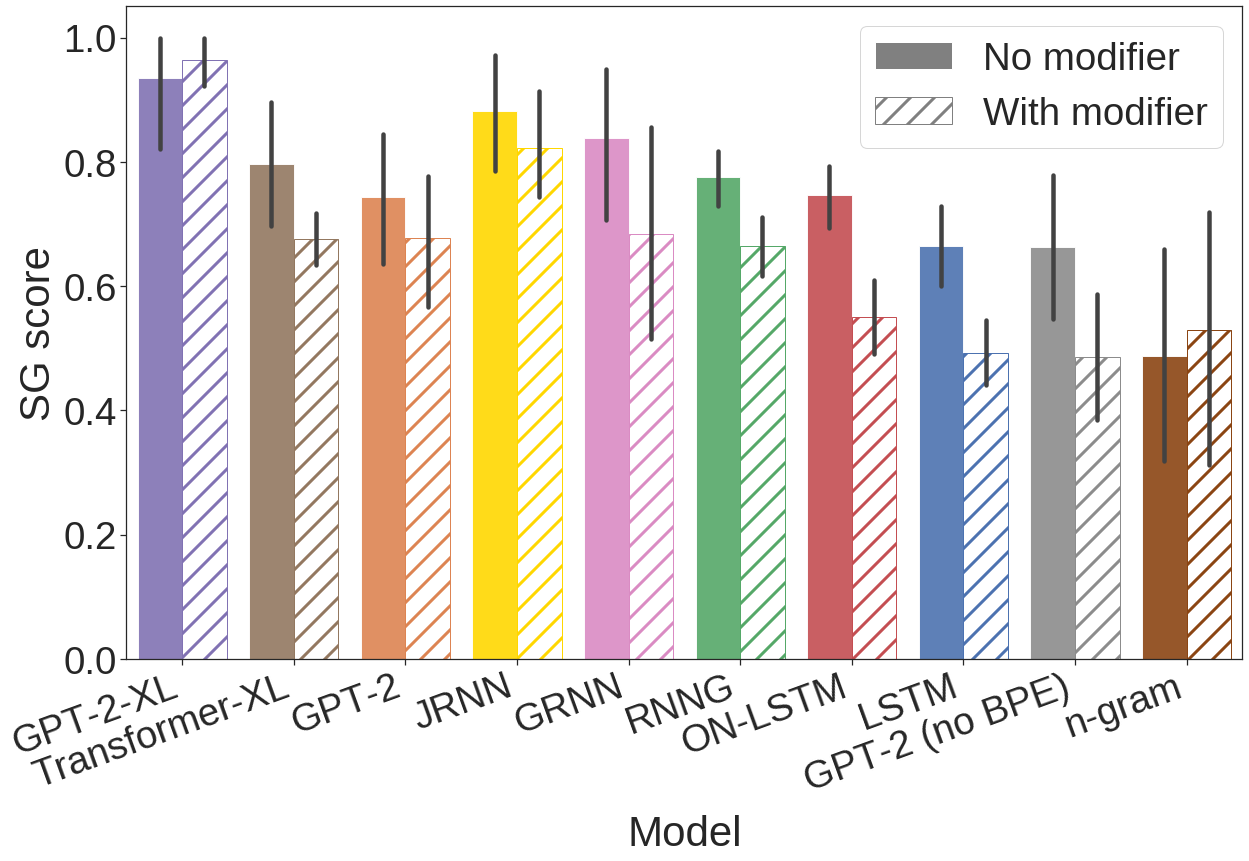

In [96]:
# Sort by decreasing average accuracy.
order = list(plot_df.groupby("pretty_model_name").correct.mean().sort_values(ascending=False).index)
# mydf = (suites_df_mod[~suites_df_mod.has_modifier].groupby("pretty_model_name").correct.mean()
#          - suites_df_mod[suites_df_mod.has_modifier].groupby("pretty_model_name").correct.mean()).abs().sort_values(ascending=False)

_, ax = plt.subplots(figsize=(20,12))
sns.barplot(data=suites_df_mod, x="pretty_model_name", y="correct",
            hue="has_modifier", order=order, ax=ax)

# Colors, hatches.
sorted_patches = sorted(ax.patches, key=lambda bar: bar.get_x())
colors = [MODEL_COLORS[order[i]] for i in range(len(order))]
for i, bar in enumerate(sorted_patches):
    if i % 2 == 0:
        bar.set_facecolor(colors[int(i/2)])
        bar.set_alpha(0.9)
    else:
        bar.set_facecolor("white")
        bar.set_edgecolor(colors[int(i/2)])
add_hatches(ax.patches, hatch=HATCH)

# Set labels.
ax.set_xlabel("Model", labelpad=16)
ax.set_ylabel(SG_ABSOLUTE_LABEL)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment="right")

# Custom legend.
handles, _ = ax.get_legend_handles_labels()
handles[0] = mpatches.Patch(facecolor="grey")
handles[1] = mpatches.Patch(facecolor="white", edgecolor="grey")
handles[1].set_hatch("/")
ax.legend(handles, MOD_STABILITY_LABELS, loc="upper right", title="")

if RENDER_FINAL:
    render_final(figure_path / "stability-all-models.pdf")

### Accuracy vs perplexity

GPT-2
GPT-2-XL
GRNN
JRNN
Random
Transformer-XL


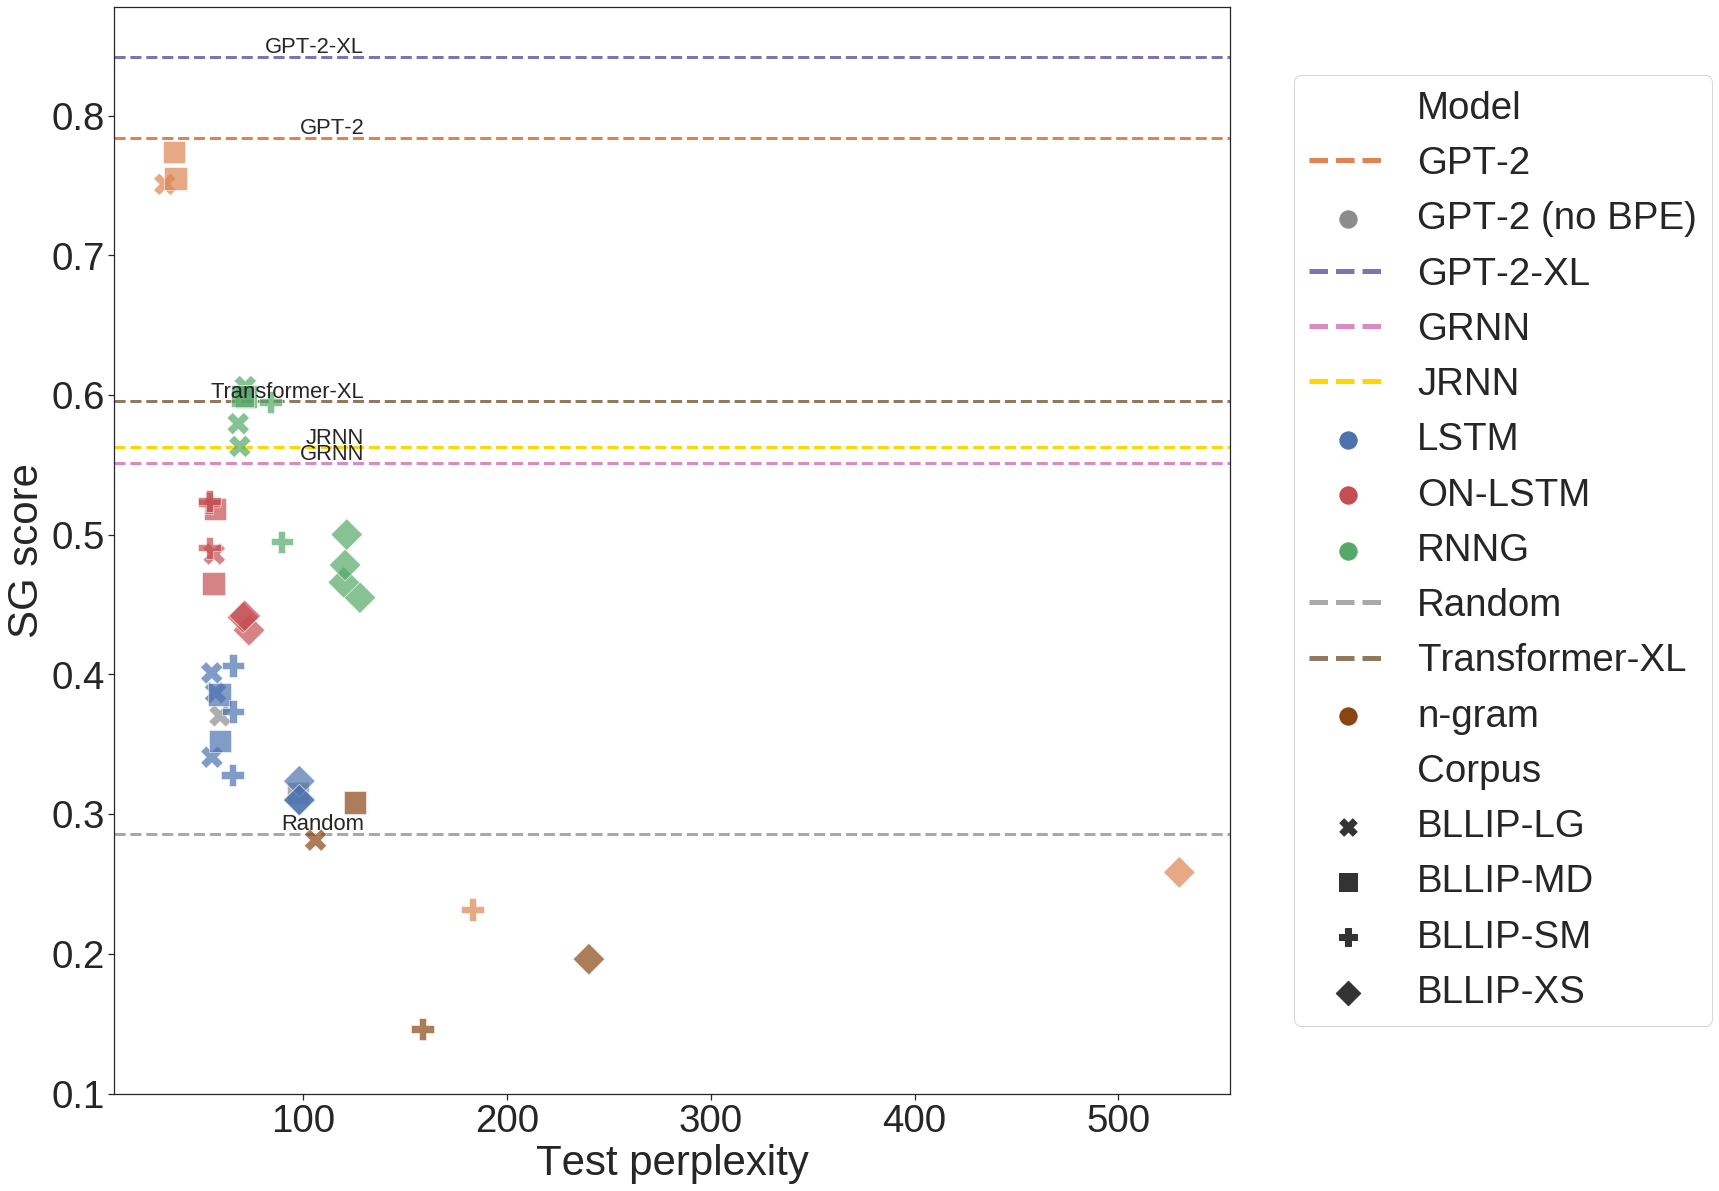

In [101]:
f, ax = plt.subplots(figsize=(20, 20))
sns.scatterplot(data=joined_data, x="test_ppl", y="correct",
                hue="pretty_model_name", style="pretty_corpus", s=500,
                hue_order=model_order, ax=ax, zorder=2, palette=MODEL_COLORS, alpha=0.7)

legend_title_map = {"pretty_model_name": "Model",
                    "pretty_corpus": "Corpus"}
handles, labels = ax.get_legend_handles_labels()
# Re-map some labels.
labels = [legend_title_map.get(l, l) for l in labels]
# Drop some legend entries.
drop_labels = ["N/A"]
drop_idxs = [labels.index(l) for l in drop_labels]
handles = [h for i, h in enumerate(handles) if i not in drop_idxs]
labels = [l for i, l in enumerate(labels) if i not in drop_idxs]
for h in handles:
    h.set_sizes([300.0])

# Prepare to look up legend color
legend_dict = dict(zip(labels, handles))

# Add horizontal lines for models without ppl estimates.
no_ppl_data = joined_data[joined_data.test_ppl.isna()]
for model_name, rows in no_ppl_data.groupby("pretty_model_name"):
    y = rows.correct.mean()
    # TODO show error region?
    
    color = tuple(legend_dict[model_name].get_facecolor()[0])
    ax.axhline(y, c=color, linestyle="dashed", zorder=1, linewidth=3)
    ax.text(130, y + 0.0025, model_name, fontdict={"size": 22}, ha='right')
    
from matplotlib.lines import Line2D
for i, h in enumerate(handles):
    if labels[i] in no_ppl_data.pretty_model_name.values:
        print(labels[i])
        handles[i] = Line2D([0], [0], color=tuple(legend_dict[labels[i]].get_facecolor()[0]), linestyle='--', linewidth=5)
plt.legend(handles, labels, bbox_to_anchor=(1.04,0.5), loc="center left")
    
plt.xlabel(PERPLEXITY_LABEL)
plt.ylabel(SG_ABSOLUTE_LABEL)

if RENDER_FINAL:
    render_final(figure_path / "perplexity.pdf")


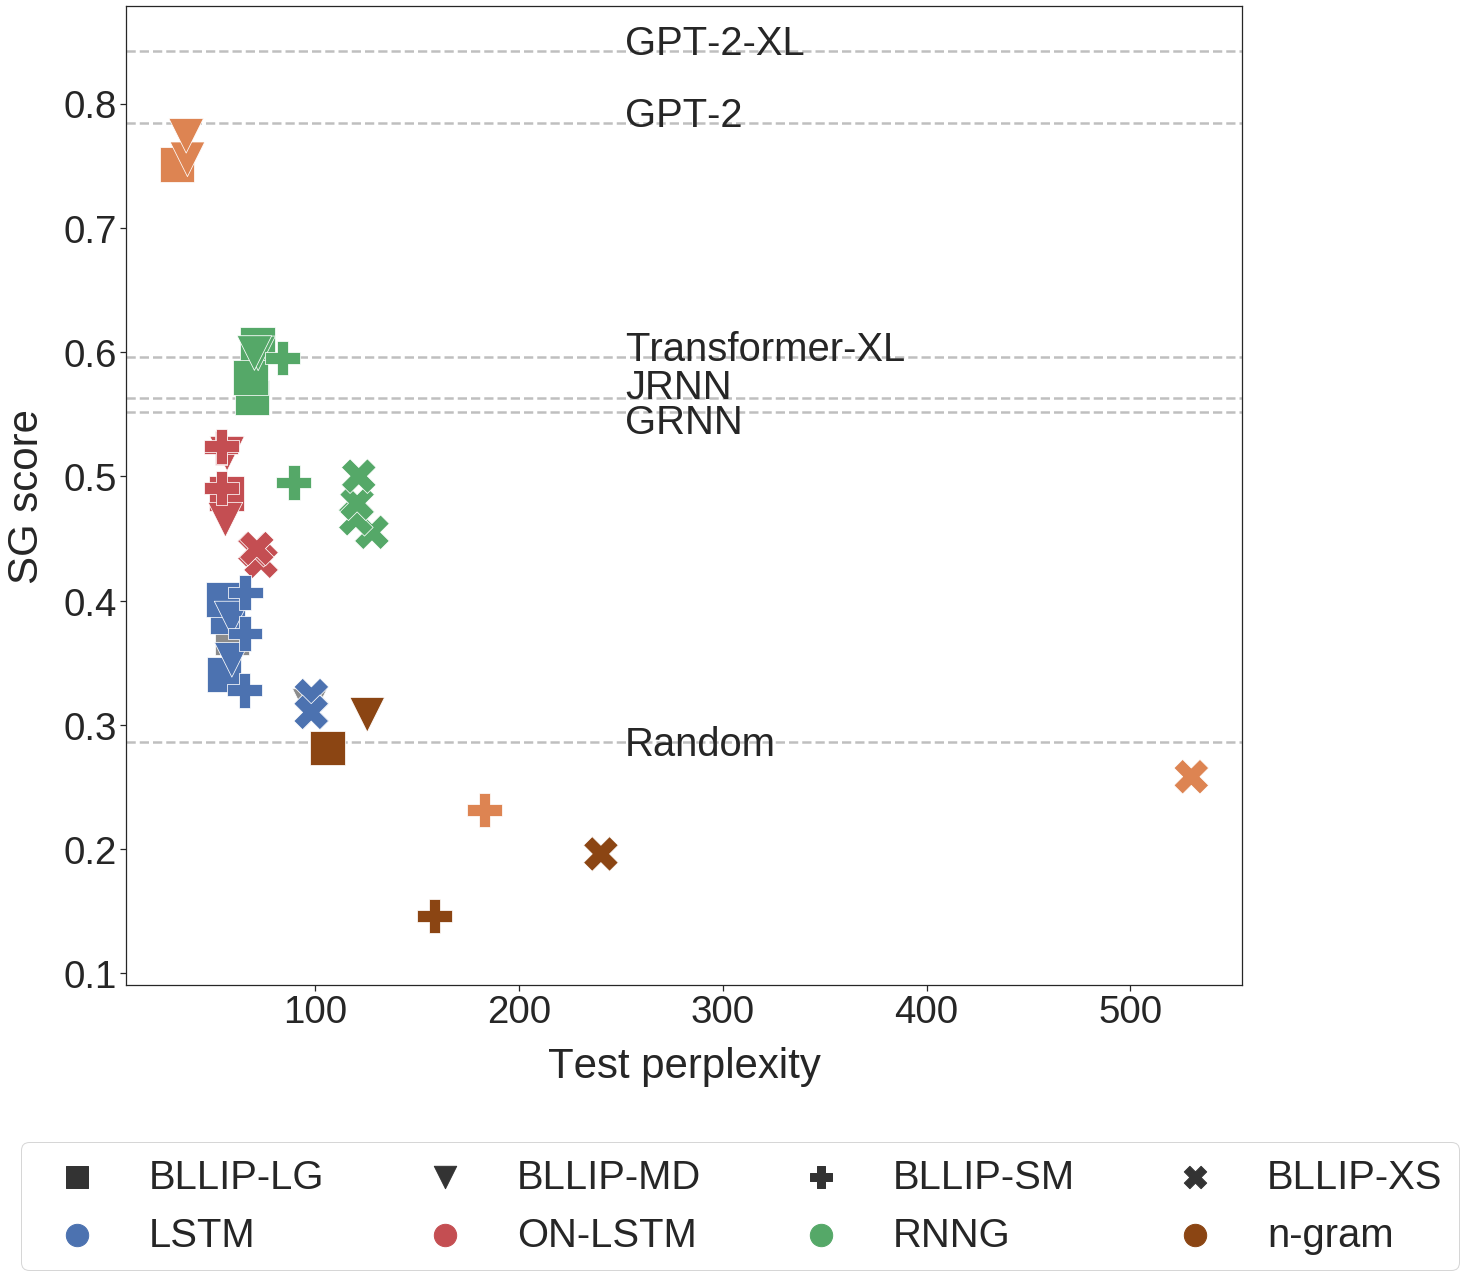

In [98]:
f, ax = plt.subplots(figsize=(20, 18))
joined_df_controlled = joined_data.dropna(subset=["test_ppl"])
sns.scatterplot(data=joined_df_controlled, x="test_ppl", y="correct",
                hue="pretty_model_name", style="pretty_corpus", s=1200, palette=MODEL_COLORS,
                hue_order=model_order, markers=CORPUS_MARKERS, ax=ax, zorder=2)

legend_title_map = {"pretty_model_name": "Model",
                    "pretty_corpus": "Corpus"}
handles, labels = ax.get_legend_handles_labels()
# Re-map some labels.
labels = [legend_title_map.get(l, l) for l in labels]
# Drop some legend entries.
drop_labels = ["Random"] # ["N/A", "Model", "Corpus", "Random"]
drop_labels.extend(no_ppl_data.pretty_model_name.unique())
drop_idxs = [labels.index(l) for l in drop_labels]
handles = [h for i, h in enumerate(handles) if i not in drop_idxs]
labels = [l for i, l in enumerate(labels) if i not in drop_idxs]

# Hand re-ordering of labels for legend.
label_order = ["BLLIP-LG", "LSTM", "BLLIP-MD", "ON-LSTM", "BLLIP-SM", "RNNG", "BLLIP-XS", "n-gram"]
label_order = [labels.index(l) for l in label_order]
handles = [handles[i] for i in label_order]
labels = [labels[i] for i in label_order]
for h in handles:
    h.set_sizes([500])
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, -0.14), ncol=4, fontsize=40)
# plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1.4, 0.5)) #, ncol=5, fontsize=40)

# Prepare to look up legend color
legend_dict = dict(zip(labels, handles))

# Add horizontal lines for models without ppl estimates.
no_ppl_data = joined_data[joined_data.test_ppl.isna()]
for model_name, rows in no_ppl_data.groupby("pretty_model_name"):
    y = rows.correct.mean()
    # TODO show error region?
    
    color = "Gray" #tuple(legend_dict[model_name].get_facecolor()[0])
    ax.axhline(y, c=color, linestyle="dashed", alpha=0.5, zorder=1)
    
    # Do some hand-tweaking of spacing.
    yoffsets = {
        "GRNN": -0.017,
        "JRNN": 0,
        "Random": -0.01
    }
    yoffset = yoffsets[model_name] if model_name in yoffsets else -0.0025
    ax.text(252, y + yoffset, model_name, fontdict={"size": 40})
    
plt.xlabel(PERPLEXITY_LABEL, labelpad=16)
plt.ylabel(SG_ABSOLUTE_LABEL, labelpad=16)

if RENDER_FINAL:
    render_final(figure_path / "perplexity.pdf")

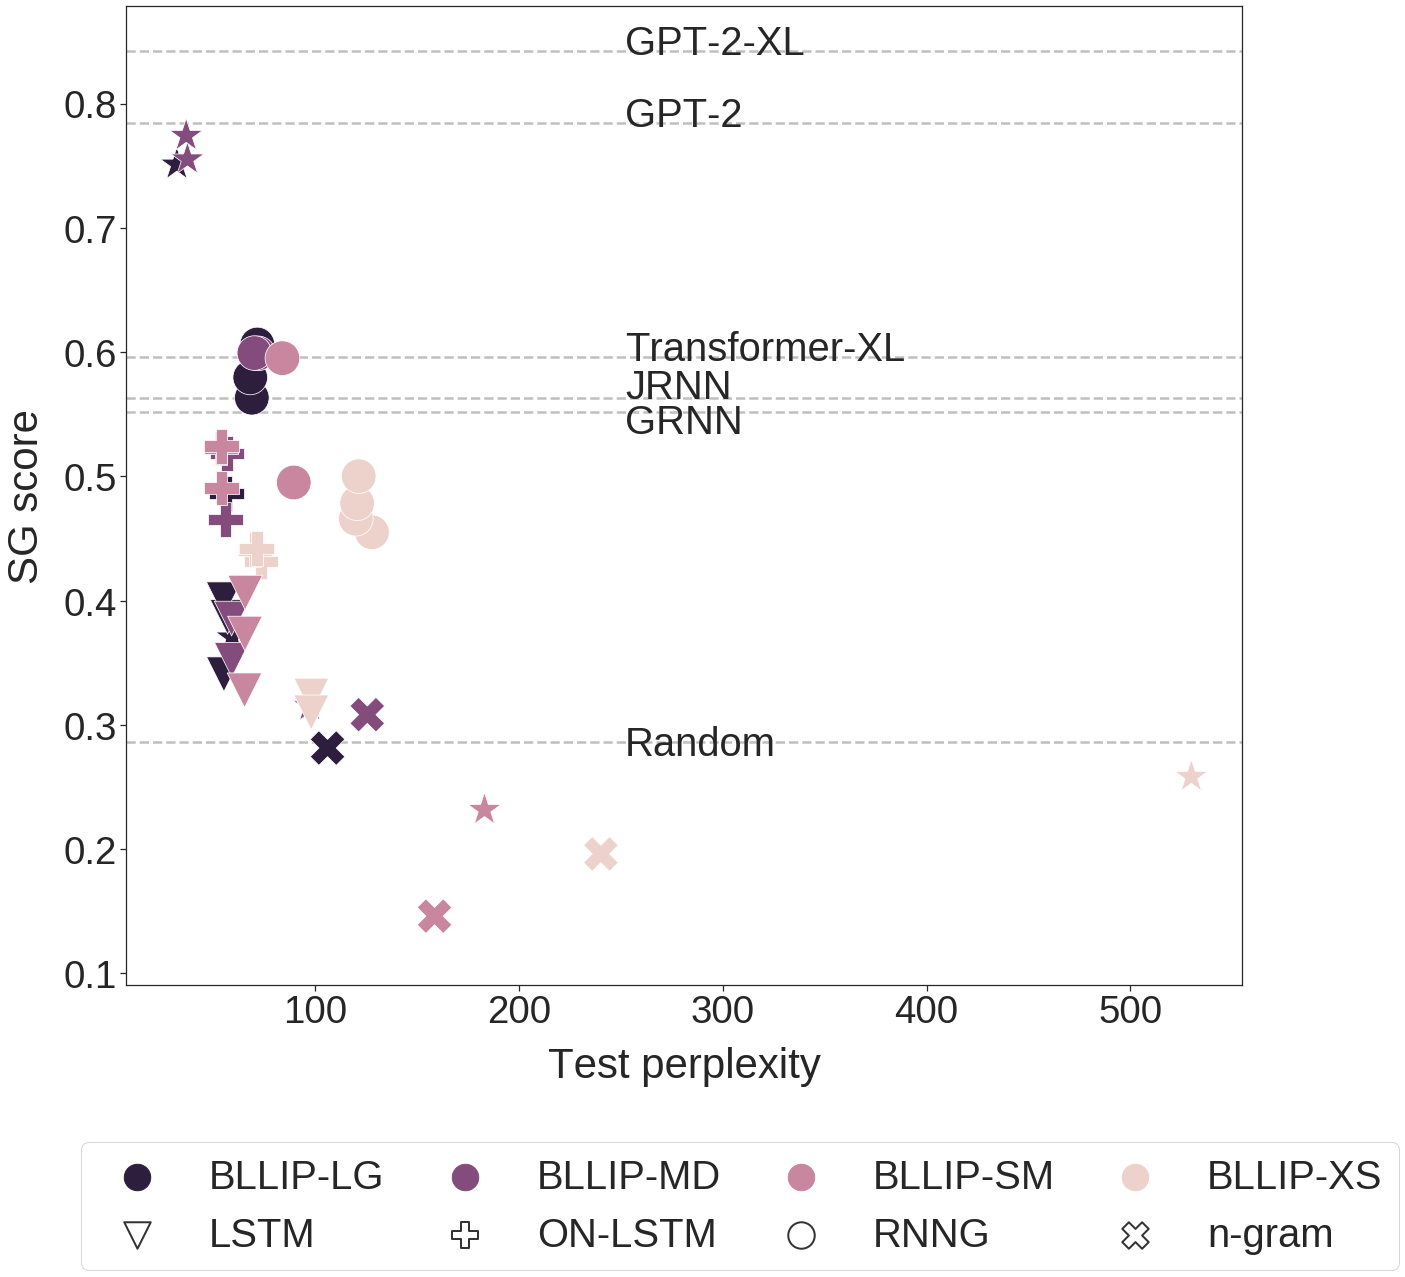

In [102]:
f, ax = plt.subplots(figsize=(20, 18))
MODEL_MARKERS={
    "n-gram":"X",
    "LSTM":"v",
    "ON-LSTM":"P",
    "RNNG": "o",
    "GPT-2": "*",
    "GPT-2 (no BPE)": "*",
}
joined_df_controlled = joined_data.dropna(subset=["test_ppl"])
sns.scatterplot(data=joined_df_controlled, x="test_ppl", y="correct",
                hue="pretty_corpus", style="pretty_model_name", s=1200, palette=sns.cubehelix_palette(4, reverse=True),
                hue_order=corpus_order,  ax=ax, zorder=2, markers=MODEL_MARKERS)

legend_title_map = {"pretty_model_name": "Model",
                    "pretty_corpus": "Corpus"}
handles, labels = ax.get_legend_handles_labels()
# Re-map some labels.
labels = [legend_title_map.get(l, l) for l in labels]
# Drop some legend entries.
# drop_labels = [] #["Random"] # ["N/A", "Model", "Corpus", "Random"]
# drop_labels.extend(no_ppl_data.pretty_model_name.unique())
# drop_idxs = [labels.index(l) for l in drop_labels]
# handles = [h for i, h in enumerate(handles) if i not in drop_idxs]
# labels = [l for i, l in enumerate(labels) if i not in drop_idxs]

# Hand re-ordering of labels for legend.
label_order = ["BLLIP-LG", "LSTM", "BLLIP-MD", "ON-LSTM", "BLLIP-SM", "RNNG", "BLLIP-XS", "n-gram"]
label_order = [labels.index(l) for l in label_order]
handles = [handles[i] for i in label_order]
labels = [labels[i] for i in label_order]
for i, h in enumerate(handles):
    h.set_sizes([700])
    if i%2 == 1:
        h.set_facecolor("white")
        h.set_linewidth(2)
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, -0.14), ncol=4, fontsize=40, columnspacing=1)

# Prepare to look up legend color
legend_dict = dict(zip(labels, handles))

# Add horizontal lines for models without ppl estimates.
no_ppl_data = joined_data[joined_data.test_ppl.isna()]
for model_name, rows in no_ppl_data.groupby("pretty_model_name"):
    y = rows.correct.mean()
    # TODO show error region?
    
    color = "Gray" #tuple(legend_dict[model_name].get_facecolor()[0])
    ax.axhline(y, c=color, linestyle="dashed", alpha=0.5, zorder=1)
    
    # Do some hand-tweaking of spacing.
    yoffsets = {
        "GRNN": -0.017,
        "JRNN": 0,
        "Random": -0.01
    }
    yoffset = yoffsets[model_name] if model_name in yoffsets else -0.0025
    ax.text(252, y + yoffset, model_name, fontdict={"size": 40})
    
plt.xlabel(PERPLEXITY_LABEL, labelpad=16)
plt.ylabel(SG_ABSOLUTE_LABEL, labelpad=16)

if RENDER_FINAL:
    render_final(figure_path / "perplexity.pdf")

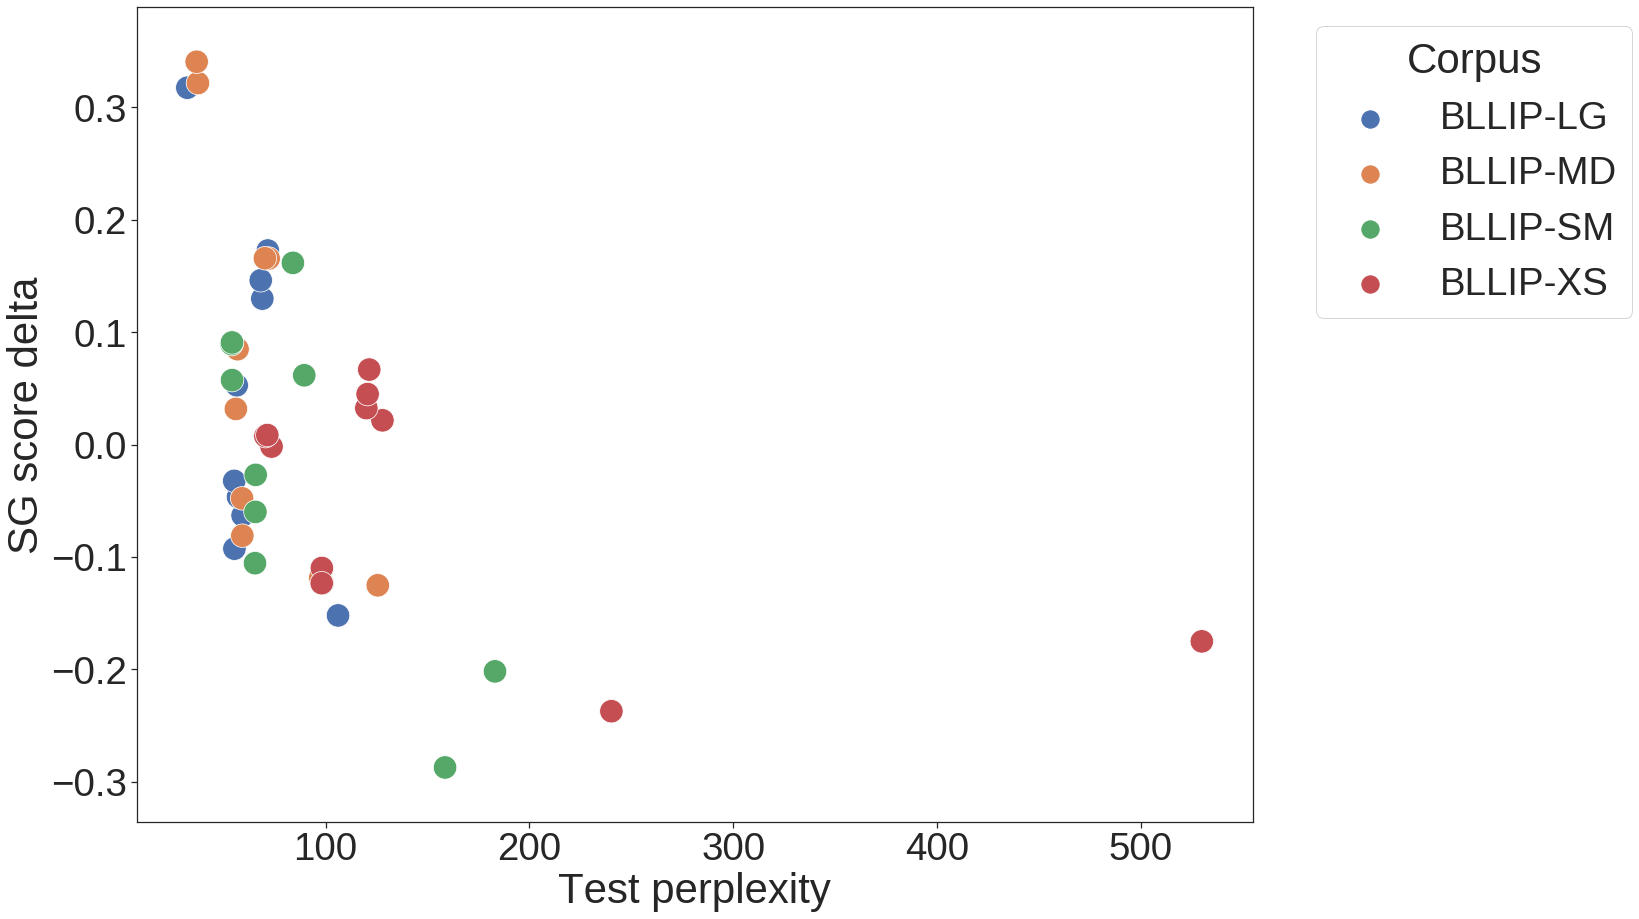

In [103]:
f, ax = plt.subplots(figsize=(20, 15))
sns.scatterplot(data=joined_data, x="test_ppl", y="correct_delta", # style="pretty_corpus", markers=CORPUS_MARKERS,
                hue="pretty_corpus", hue_order=corpus_order, s=550, ax=ax)

handles, labels = ax.get_legend_handles_labels()
# Remove `pretty_corpus` extraneous label
assert labels[0] == "pretty_corpus", "Check this figure -- something changed"
handles, labels = handles[1:], labels[1:]
for h in handles:
    h.set_sizes([300.0])
plt.legend(handles, labels, bbox_to_anchor=(1.04,1), loc="upper left", title="Corpus")
#g.ax.set_ylim((joined_data.correct_delta.min() - 0.1, joined_data.correct_delta.max() + 0.1))

plt.xlabel(PERPLEXITY_LABEL)
plt.ylabel(SG_DELTA_LABEL)

if RENDER_FINAL:
    render_final(figure_path / "perplexity_corpus.png")

## Circuit–circuit correlations

In [104]:
# Exclude some models from circuit correlation analysis.
EXCLUDE_FROM_CIRCUIT_ANALYSIS = ["random", "ngram", "1gram", "ngram-single"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  del sys.path[0]


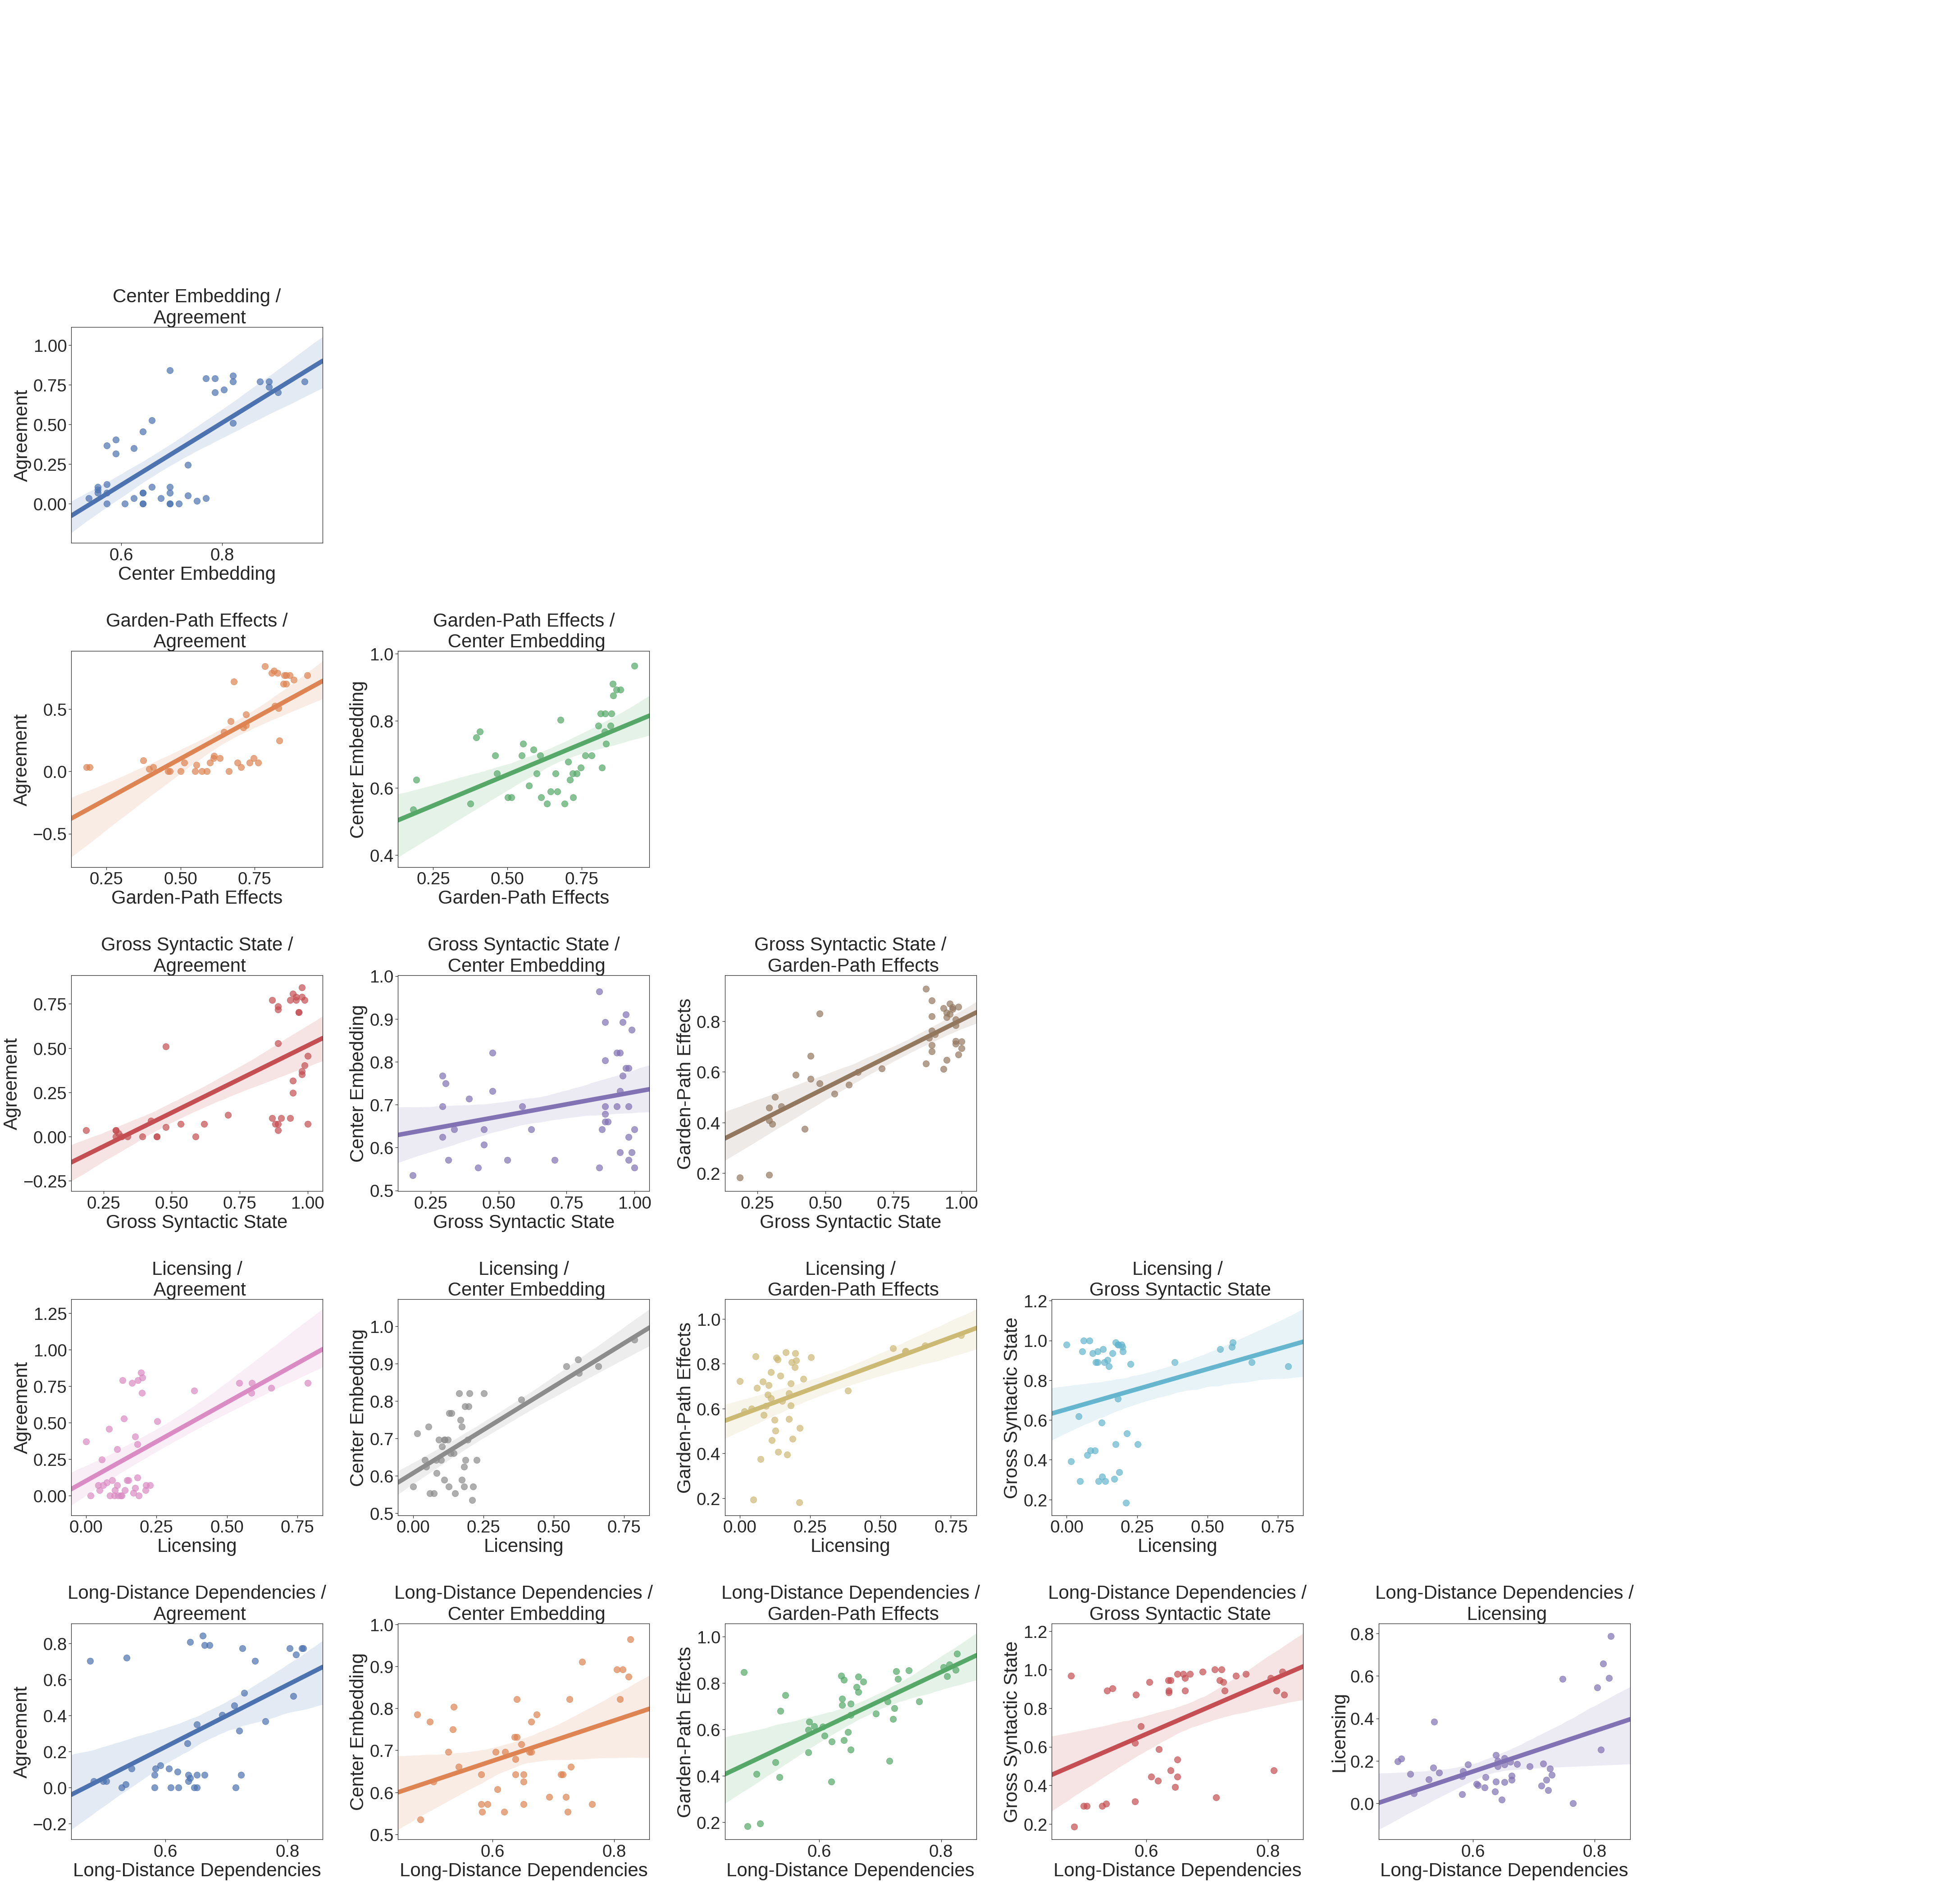

In [105]:
f, axs = plt.subplots(len(circuit_order), len(circuit_order), figsize=(75, 75))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

source_df = suites_df[~suites_df.model_name.isin(EXCLUDE_FROM_CIRCUIT_ANALYSIS)]

for c1, row in zip(circuit_order, axs):
    for c2, ax in zip(circuit_order, row):
        if c1 <= c2:
            ax.axis("off")
            continue
            
        xs = source_df[source_df.circuit == c1].groupby(["model_name", "corpus", "seed"]).correct.agg({c1: "mean"})
        ys = source_df[source_df.circuit == c2].groupby(["model_name", "corpus", "seed"]).correct.agg({c2: "mean"})
        df = pd.concat([xs, ys], axis=1)
        ax.set_title("%s /\n %s" % (c1, c2))
        sns.regplot(data=df, x=c1, y=c2, ax=ax, line_kws=dict(linewidth=10), scatter_kws=dict(s=200, alpha=0.7))
        
if RENDER_FINAL:
    render_final(figure_path / "all-correlations.pdf")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # This is added back by InteractiveShellApp.init_path()


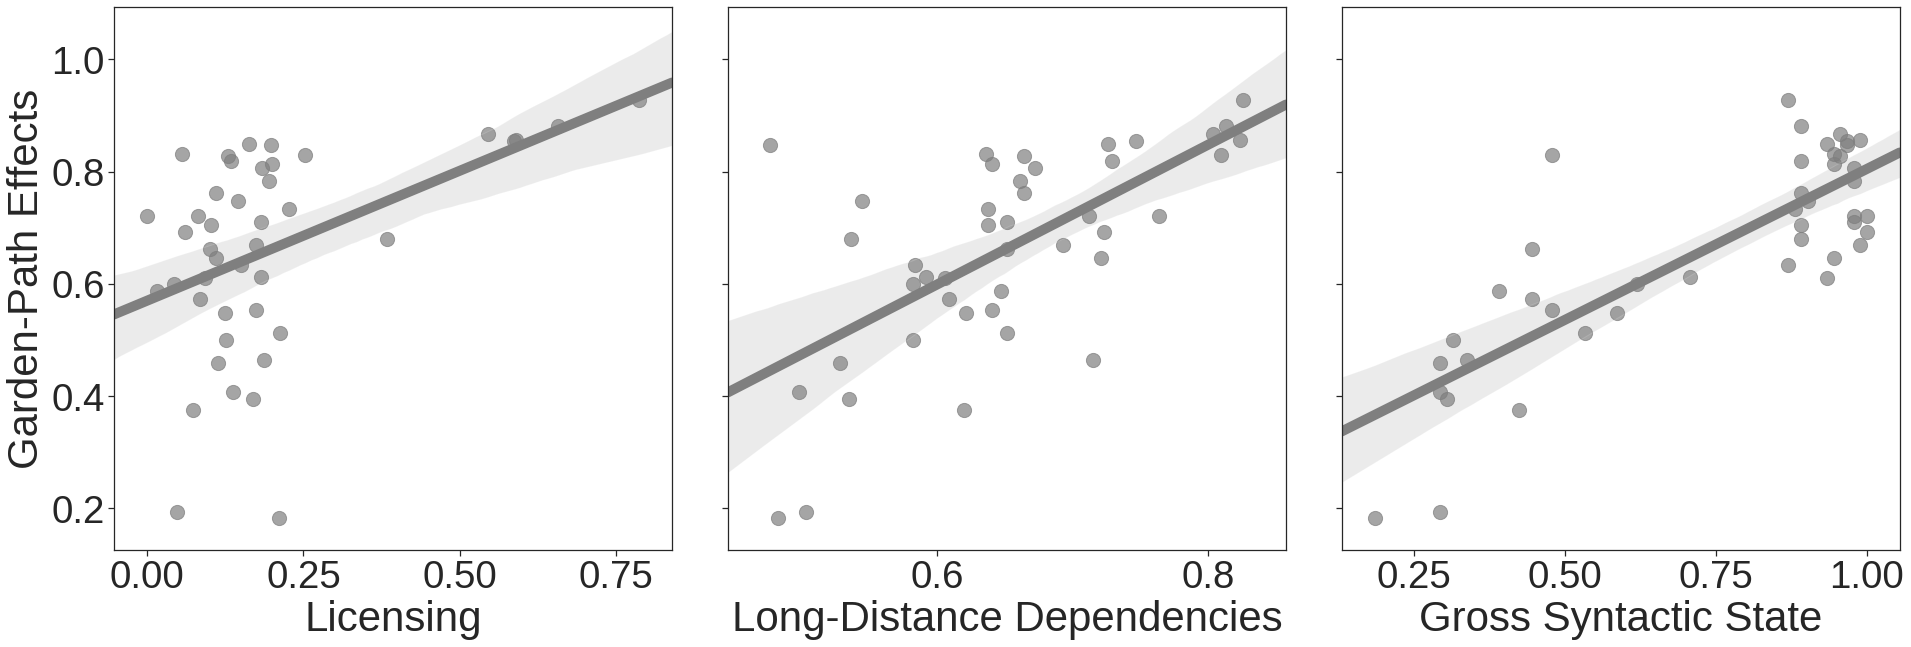

In [106]:
f, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(32,10))
plt.subplots_adjust(wspace=0.1)

source_df = suites_df[~suites_df.model_name.isin(EXCLUDE_FROM_CIRCUIT_ANALYSIS)]

cy = "Garden-Path Effects"
cxs = ["Licensing", "Long-Distance Dependencies", "Gross Syntactic State"]
for i, ax in enumerate(axes):
    cx = cxs[i]
    xs = source_df[source_df.circuit == cx].groupby(["model_name", "corpus", "seed"]).correct.agg({cx: "mean"})
    ys = source_df[source_df.circuit == cy].groupby(["model_name", "corpus", "seed"]).correct.agg({cy: "mean"})
    df = pd.concat([xs, ys], axis=1)
    sns.regplot(data=df, x=cx, y=cy, ax=ax, color="tab:grey",
                line_kws=dict(linewidth=10), scatter_kws=dict(s=200, alpha=0.7))
    if i > 0:
        ax.set_ylabel("")
        
if RENDER_FINAL:
    render_final(figure_path / "correlations.pdf")